In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36191")
client

<Client: 'tcp://127.0.0.1:36191' processes=4 threads=12, memory=31.22 GiB>

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

import xarray as xr
import pandas as pd
import os
os.environ['ESMFMKFILE']="/home/guido/miniforge3/lib/esmf.mk"

import xesmf as xe
import cartopy as cart
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cart.config['data_dir'] = os.getenv('CARTOPY_DIR', cart.config.get('data_dir'))
from scipy import integrate
import cmocean as ocncm
from scipy import signal
from xarrayutils.plotting import linear_piecewise_scale
import cmocean as ocm
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.feature as cfeature
import cartopy as cc
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import matplotlib.colors as mcolors

from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# widgets stuff
import ipywidgets as widgets
from ipywidgets import interact, interactive
from ipywidgets import Checkbox

# import the pop xgcmgrid module 
import xgcm
from xgcm import as_grid_ufunc
import pop_tools
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /home/guido/miniforge3/share/proj failed


In [5]:
def setaxesfsize(axl,fontsize, xlabel, ylabel, labsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
#    i=0
    for labely in ticklabelleft:
#        if i != 0:
            labely.set_fontsize(fontsize)
    
    axl.set_xlabel(xlabel, size=labsize)
    axl.set_ylabel(ylabel, size=labsize)


In [6]:
# data (climatology) loader 
# e.g. g1850ecoctrl1deg_ANN_051912_056911_climo.nc
gcase_ebm = "g1850ecoctrl1deg"
gcase_noebm = "g1850econoest1deg"
bcase_ebm = "B1850_BPRP_f19_g17_ref"
bcase_noebm = "B1850_BPRP_f19_g17_noest"
basedir = "/mdata/climo/"
month="ANN"
sequence = "051912_056911"
# no need for chuncking time
def climoloader(bdir, case, model, var, seq):
    xrvar = xr.open_dataset(bdir + "/" + case + "/" + model + "/" + case + "_" + month + "_" + seq +"_climo.nc", engine='netcdf4')
    return xrvar[var]


In [7]:
# test load SALT
saltvar = climoloader(basedir, bcase_ebm, "ocn", "SALT", sequence).squeeze()

In [8]:
#saltvar_rg =regridder(saltvar)
#saltvar_rg.attrs = saltvar.attrs
#saltvar_rg.to_dataset(name=saltvar.name).assign_attrs(saltvar.attrs)

In [9]:
aicevar = climoloader(basedir, bcase_ebm, "ice", "aice", sequence).squeeze()

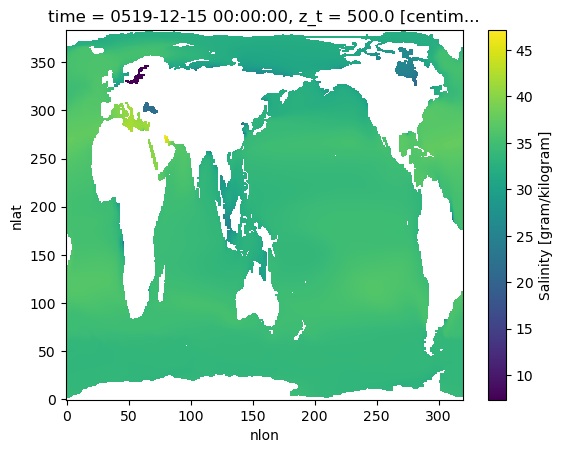

In [10]:
saltvar.isel(z_t=0).plot()

In [11]:
# need to use xesmf to transform the grid
lon = np.linspace(-180.,180.,361)
lat = np.linspace(-90.,90.,181)
# double it for zoom are in amazon
#lon = np.linspace(-180.,180., 721)
#lat = np.linspace(-90.,90.,361)
# regrider
grid_in = {'lon': saltvar['TLONG'], 'lat': saltvar['TLAT']}
grid_out = {'lon': lon, 'lat': lat}
regridder_base = xe.Regridder(grid_in, grid_out, 'nearest_s2d', reuse_weights=False)
def regridder(var):
    var_attrs  = var.attrs
    var_name  = var.name
    #print(var_atts)
    #print(var_name)
    xarr_rg = regridder_base(var).drop("time").assign_attrs(var_attrs)
    xard_rg = xarr_rg.to_dataset(name=var_name)
    return  xard_rg

In [12]:
saltvar = climoloader(basedir, bcase_ebm, "ocn", "SALT", sequence).squeeze()
saltrg = regridder(saltvar)
saltrg

<xarray.Dataset>
Dimensions:  (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    SALT     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [13]:
# need to use xesmf to transform the sea ice grid
ilon = np.linspace(-180.,180.,361)
ilat = np.linspace(-90.,90.,181)
#ilon = np.linspace(-180.,180.,721)
#ilat = np.linspace(-90.,90.,361)
# regrider
igrid_in = {'lon': aicevar['TLON'], 'lat': aicevar['TLAT']}
igrid_out = {'lon': ilon, 'lat': ilat}
iregridder_base = xe.Regridder(igrid_in, igrid_out, 'nearest_s2d', reuse_weights=False)
def iregridder(var):
    var_attrs  = var.attrs
    var_name  = var.name
    #print(var_atts)
    #print(var_name)
    xarr_rg = iregridder_base(var).drop("time").assign_attrs(var_attrs)
    xard_rg = xarr_rg.to_dataset(name=var_name)
    return  xard_rg

In [14]:
# load 50 year averages for all cases
month="ANN"
sequence = "051912_056911"


In [15]:
####### g1850ecoctrl1deg g1850econoebm1deg
basedir = "/mdata/climo/"
gcase_ebm = "g1850ecoctrl1deg"
gcase_noebm = "g1850econoest1deg"

gebm_SALT = regridder(climoloader(basedir, gcase_ebm, "ocn", "SALT", sequence).squeeze())  # for 4-D var
gnoebm_SALT = regridder(climoloader(basedir, gcase_noebm, "ocn", "SALT", sequence).squeeze())
gdiff_SALT = gebm_SALT - gnoebm_SALT 

gebm_SSS = gebm_SALT.isel(z_t = 0).squeeze().drop("z_t")
gnoebm_SSS = gnoebm_SALT.isel(z_t = 0).squeeze().drop("z_t")
gdiff_SSS = gebm_SSS - gnoebm_SSS 

gebm_TEMP = regridder(climoloader(basedir, gcase_ebm, "ocn", "TEMP", sequence).squeeze())  # for 4-D var
gnoebm_TEMP = regridder(climoloader(basedir, gcase_noebm, "ocn", "TEMP", sequence).squeeze())
gdiff_TEMP = gebm_TEMP - gnoebm_TEMP

gebm_SST = gebm_TEMP.isel(z_t = 0).squeeze().drop("z_t")
gnoebm_SST = gnoebm_TEMP.isel(z_t = 0).squeeze().drop("z_t")
gdiff_SST = gebm_SST - gnoebm_SST 

gebm_UVEL = regridder(climoloader(basedir, gcase_ebm, "ocn", "UVEL", sequence).squeeze())  # for 4-D var
gnoebm_UVEL = regridder(climoloader(basedir, gcase_noebm, "ocn", "UVEL", sequence).squeeze())
gdiff_UVEL = gebm_UVEL - gnoebm_UVEL

gebm_VVEL = regridder(climoloader(basedir, gcase_ebm, "ocn", "VVEL", sequence).squeeze())  # for 4-D var
gnoebm_VVEL = regridder(climoloader(basedir, gcase_noebm, "ocn", "VVEL", sequence).squeeze())
gdiff_VVEL = gebm_VVEL - gnoebm_VVEL


gebm_XBLT = regridder(climoloader(basedir, gcase_ebm, "ocn", "XBLT", sequence).squeeze()) # for 3-D var
gnoebm_XBLT = regridder(climoloader(basedir, gcase_noebm, "ocn", "XBLT", sequence).squeeze())
gdiff_XBLT =  gebm_XBLT - gnoebm_XBLT

gebm_HMXL = regridder(climoloader(basedir, gcase_ebm, "ocn", "HMXL", sequence).squeeze()) # for 3-D var
gnoebm_HMXL = regridder(climoloader(basedir, gcase_noebm, "ocn", "HMXL", sequence).squeeze())
gdiff_HMXL =  gebm_HMXL - gnoebm_HMXL

gebm_SFWF = regridder(climoloader(basedir, gcase_ebm, "ocn", "SFWF", sequence).squeeze()) # for 3-D var
gnoebm_SFWF = regridder(climoloader(basedir, gcase_noebm, "ocn", "SFWF", sequence).squeeze())
gdiff_SFWF =  gebm_SFWF - gnoebm_SFWF

gebm_spChl = regridder(climoloader(basedir, gcase_ebm, "ocn", "spChl", sequence).squeeze()) # for 3-D var
gnoebm_spChl = regridder(climoloader(basedir, gcase_noebm, "ocn", "spChl", sequence).squeeze())
gdiff_spChl =  gebm_spChl - gnoebm_spChl

gebm_diazChl = regridder(climoloader(basedir, gcase_ebm, "ocn", "diazChl", sequence).squeeze()) # for 3-D var
gnoebm_diazChl = regridder(climoloader(basedir, gcase_noebm, "ocn", "diazChl", sequence).squeeze())
gdiff_diazChl =  gebm_diazChl - gnoebm_diazChl

gebm_diatChl = regridder(climoloader(basedir, gcase_ebm, "ocn", "diatChl", sequence).squeeze()) # for 3-D var
gnoebm_diatChl = regridder(climoloader(basedir, gcase_noebm, "ocn", "diatChl", sequence).squeeze())
gdiff_diatChl =  gebm_diatChl - gnoebm_diatChl

gebm_MOC = climoloader(basedir, gcase_ebm, "ocn", "MOC", sequence).squeeze() # for 3-D var
gnoebm_MOC = climoloader(basedir, gcase_noebm, "ocn", "MOC", sequence).squeeze()
gdiff_MOC =  gebm_MOC - gnoebm_MOC

gebm_POC_FLUX_IN = regridder(climoloader(basedir, gcase_ebm, "ocn", "POC_FLUX_IN", sequence).squeeze())  # for 4-D var
gnoebm_POC_FLUX_IN = regridder(climoloader(basedir, gcase_noebm, "ocn", "POC_FLUX_IN", sequence).squeeze())
gdiff_POC_FLUX_IN = gebm_POC_FLUX_IN - gnoebm_POC_FLUX_IN 

gebm_POC_FLUX_100m = regridder(climoloader(basedir, gcase_ebm, "ocn", "POC_FLUX_100m", sequence).squeeze()) # for 3-D var
gnoebm_POC_FLUX_100m = regridder(climoloader(basedir, gcase_noebm, "ocn", "POC_FLUX_100m", sequence).squeeze())
gdiff_POC_FLUX_100m =  gebm_POC_FLUX_100m - gnoebm_POC_FLUX_100m

gebm_PO4 = regridder(climoloader(basedir, gcase_ebm, "ocn", "PO4", sequence).squeeze())  # for 4-D var
gnoebm_PO4 = regridder(climoloader(basedir, gcase_noebm, "ocn", "PO4", sequence).squeeze())
gdiff_PO4 = gebm_PO4 - gnoebm_PO4 

gebm_SSPO4 = gebm_PO4.isel(z_t = 0).squeeze().drop("z_t")
gnoebm_SSPO4 = gnoebm_PO4.isel(z_t = 0).squeeze().drop("z_t")
gdiff_SSPO4 = gebm_SSPO4 - gnoebm_SSPO4

gebm_NO3 = regridder(climoloader(basedir, gcase_ebm, "ocn", "NO3", sequence).squeeze())  # for 4-D var
gnoebm_NO3 = regridder(climoloader(basedir, gcase_noebm, "ocn", "NO3", sequence).squeeze())
gdiff_NO3 = gebm_NO3 - gnoebm_NO3 

gebm_SSNO3 = gebm_NO3.isel(z_t = 0).squeeze().drop("z_t")
gnoebm_SSNO3 = gnoebm_NO3.isel(z_t = 0).squeeze().drop("z_t")
gdiff_SSNO3 = gebm_SSNO3 - gnoebm_SSNO3

gebm_SiO3 = regridder(climoloader(basedir, gcase_ebm, "ocn", "SiO3", sequence).squeeze())  # for 4-D var
gnoebm_SiO3 = regridder(climoloader(basedir, gcase_noebm, "ocn", "SiO3", sequence).squeeze())
gdiff_SiO3 = gebm_SiO3 - gnoebm_SiO3 

gebm_O2 = regridder(climoloader(basedir, gcase_ebm, "ocn", "O2", sequence).squeeze())  # for 4-D var
gnoebm_O2 = regridder(climoloader(basedir, gcase_noebm, "ocn", "O2", sequence).squeeze())
gdiff_O2 = gebm_O2 - gnoebm_O2 

gebm_ALK = regridder(climoloader(basedir, gcase_ebm, "ocn", "ALK", sequence).squeeze()) # for 3-D var
gnoebm_ALK = regridder(climoloader(basedir, gcase_noebm, "ocn", "ALK", sequence).squeeze())
gdiff_ALK =  gebm_ALK - gnoebm_ALK

gebm_SSALK = gebm_ALK.isel(z_t = 0).squeeze().drop("z_t")
gnoebm_SSALK = gnoebm_ALK.isel(z_t = 0).squeeze().drop("z_t")
gdiff_SSALK = gebm_SSALK - gnoebm_SSALK 

gebm_PO4_RIV_FLUX = regridder(climoloader(basedir, gcase_ebm, "ocn", "PO4_RIV_FLUX", sequence).squeeze())  # for 3-D var
gnoebm_PO4_RIV_FLUX = regridder(climoloader(basedir, gcase_noebm, "ocn", "PO4_RIV_FLUX", sequence).squeeze())
gdiff_PO4_RIV_FLUX = gebm_PO4_RIV_FLUX - gnoebm_PO4_RIV_FLUX 

gebm_SiO3_RIV_FLUX = regridder(climoloader(basedir, gcase_ebm, "ocn", "SiO3_RIV_FLUX", sequence).squeeze())  # for 3-D var
gnoebm_SiO3_RIV_FLUX = regridder(climoloader(basedir, gcase_noebm, "ocn", "SiO3_RIV_FLUX", sequence).squeeze())
gdiff_SiO3_RIV_FLUX = gebm_SiO3_RIV_FLUX - gnoebm_SiO3_RIV_FLUX 

gebm_NO3_RIV_FLUX = regridder(climoloader(basedir, gcase_ebm, "ocn", "NO3_RIV_FLUX", sequence).squeeze())  # for 3-D var
gnoebm_NO3_RIV_FLUX = regridder(climoloader(basedir, gcase_noebm, "ocn", "NO3_RIV_FLUX", sequence).squeeze())
gdiff_NO3_RIV_FLUX = gebm_NO3_RIV_FLUX - gnoebm_NO3_RIV_FLUX 

gebm_FG_CO2 = regridder(climoloader(basedir, gcase_ebm, "ocn", "FG_CO2", sequence).squeeze()) # for 3-D var
gnoebm_FG_CO2 = regridder(climoloader(basedir, gcase_noebm, "ocn", "FG_CO2", sequence).squeeze())
gdiff_FG_CO2 =  gebm_FG_CO2 - gnoebm_FG_CO2


In [16]:
gebm_ROFF = regridder(climoloader(basedir, gcase_ebm, "ocn", "ROFF_F", sequence).squeeze())  # for 4-D var
gnoebm_ROFF = regridder(climoloader(basedir, gcase_noebm, "ocn", "ROFF_F", sequence).squeeze())
gdiff_ROFF = gebm_ROFF - gnoebm_ROFF


In [17]:
gebm_SSNO3

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    NO3      (lat, lon) float32 nan nan nan nan nan ... 1.254 1.254 1.254 1.254

In [18]:
month="03"
sequence="052003_056903"
gebm_aice_mar = iregridder(climoloader(basedir, gcase_ebm, "ice", "aice", sequence).squeeze()) # for 3-D var
gnoebm_aice_mar = iregridder(climoloader(basedir, gcase_noebm, "ice", "aice", sequence).squeeze())
gdiff_aice_mar =  gebm_aice_mar - gnoebm_aice_mar
month="09"
sequence="052009_056909"
gebm_aice_sep = iregridder(climoloader(basedir, gcase_ebm, "ice", "aice", sequence).squeeze()) # for 3-D var
gnoebm_aice_sep = iregridder(climoloader(basedir, gcase_noebm, "ice", "aice", sequence).squeeze())
gdiff_aice_sep =  gebm_aice_sep - gnoebm_aice_sep
month="ANN"
sequence="051912_056911"
gebm_aice_ann = iregridder(climoloader(basedir, gcase_ebm, "ice", "aice", sequence).squeeze()) # for 3-D var
gnoebm_aice_ann = iregridder(climoloader(basedir, gcase_noebm, "ice", "aice", sequence).squeeze())
gdiff_aice_ann =  gebm_aice_ann - gnoebm_aice_ann

In [19]:
####### 
basedir = "/mdata/climo/"
bcase_ebm = "B1850_BPRP_f19_g17_ref"
bcase_noebm = "B1850_BPRP_f19_g17_noest"

bebm_SALT = regridder(climoloader(basedir, bcase_ebm, "ocn", "SALT", sequence).squeeze())  # for 4-D var
bnoebm_SALT = regridder(climoloader(basedir, bcase_noebm, "ocn", "SALT", sequence).squeeze())
bdiff_SALT = bebm_SALT - bnoebm_SALT 

bebm_SSS = bebm_SALT.isel(z_t = 0).squeeze().drop("z_t")
bnoebm_SSS = bnoebm_SALT.isel(z_t = 0).squeeze().drop("z_t")
bdiff_SSS = bebm_SSS - bnoebm_SSS 

bebm_TEMP = regridder(climoloader(basedir, bcase_ebm, "ocn", "TEMP", sequence).squeeze())  # for 4-D var
bnoebm_TEMP = regridder(climoloader(basedir, bcase_noebm, "ocn", "TEMP", sequence).squeeze())
bdiff_TEMP = bebm_TEMP - bnoebm_TEMP

bebm_SST = bebm_TEMP.isel(z_t = 0).squeeze().drop("z_t")
bnoebm_SST = bnoebm_TEMP.isel(z_t = 0).squeeze().drop("z_t")
bdiff_SST = bebm_SST - bnoebm_SST 

bebm_UVEL = regridder(climoloader(basedir, bcase_ebm, "ocn", "UVEL", sequence).squeeze())  # for 4-D var
bnoebm_UVEL = regridder(climoloader(basedir, bcase_noebm, "ocn", "UVEL", sequence).squeeze())
bdiff_UVEL = bebm_UVEL - bnoebm_UVEL

bebm_VVEL = regridder(climoloader(basedir, bcase_ebm, "ocn", "VVEL", sequence).squeeze())  # for 4-D var
bnoebm_VVEL = regridder(climoloader(basedir, bcase_noebm, "ocn", "VVEL", sequence).squeeze())
bdiff_VVEL = bebm_VVEL - bnoebm_VVEL

bebm_XBLT = regridder(climoloader(basedir, bcase_ebm, "ocn", "XBLT", sequence).squeeze()) # for 3-D var
bnoebm_XBLT = regridder(climoloader(basedir, bcase_noebm, "ocn", "XBLT", sequence).squeeze())
bdiff_XBLT =  bebm_XBLT - bnoebm_XBLT

bebm_HMXL = regridder(climoloader(basedir, bcase_ebm, "ocn", "HMXL", sequence).squeeze()) # for 3-D var
bnoebm_HMXL = regridder(climoloader(basedir, bcase_noebm, "ocn", "HMXL", sequence).squeeze())
bdiff_HMXL =  bebm_HMXL - bnoebm_HMXL

bebm_SFWF = regridder(climoloader(basedir, bcase_ebm, "ocn", "SFWF", sequence).squeeze()) # for 3-D var
bnoebm_SFWF = regridder(climoloader(basedir, bcase_noebm, "ocn", "SFWF", sequence).squeeze())
bdiff_SFWF =  bebm_SFWF - bnoebm_SFWF

bebm_spChl = regridder(climoloader(basedir, bcase_ebm, "ocn", "spChl", sequence).squeeze()) # for 3-D var
bnoebm_spChl = regridder(climoloader(basedir, bcase_noebm, "ocn", "spChl", sequence).squeeze())
bdiff_spChl =  bebm_spChl - bnoebm_spChl

bebm_diazChl = regridder(climoloader(basedir, bcase_ebm, "ocn", "diazChl", sequence).squeeze()) # for 3-D var
bnoebm_diazChl = regridder(climoloader(basedir, bcase_noebm, "ocn", "diazChl", sequence).squeeze())
bdiff_diazChl =  bebm_diazChl - bnoebm_diazChl

bebm_diatChl = regridder(climoloader(basedir, bcase_ebm, "ocn", "diatChl", sequence).squeeze()) # for 3-D var
bnoebm_diatChl = regridder(climoloader(basedir, bcase_noebm, "ocn", "diatChl", sequence).squeeze())
bdiff_diatChl =  bebm_diatChl - bnoebm_diatChl

bebm_MOC = climoloader(basedir, bcase_ebm, "ocn", "MOC", sequence).squeeze() # for 3-D var
bnoebm_MOC = climoloader(basedir, bcase_noebm, "ocn", "MOC", sequence).squeeze()
bdiff_MOC =  bebm_MOC - bnoebm_MOC

bebm_POC_FLUX_IN = regridder(climoloader(basedir, bcase_ebm, "ocn", "POC_FLUX_IN", sequence).squeeze())  # for 4-D var
bnoebm_POC_FLUX_IN = regridder(climoloader(basedir, bcase_noebm, "ocn", "POC_FLUX_IN", sequence).squeeze())
bdiff_POC_FLUX_IN = bebm_POC_FLUX_IN - bnoebm_POC_FLUX_IN 

bebm_POC_FLUX_100m = regridder(climoloader(basedir, bcase_ebm, "ocn", "POC_FLUX_100m", sequence).squeeze()) # for 3-D var
bnoebm_POC_FLUX_100m = regridder(climoloader(basedir, bcase_noebm, "ocn", "POC_FLUX_100m", sequence).squeeze())
bdiff_POC_FLUX_100m =  bebm_POC_FLUX_100m - bnoebm_POC_FLUX_100m

bebm_PO4 = regridder(climoloader(basedir, bcase_ebm, "ocn", "PO4", sequence).squeeze())  # for 4-D var
bnoebm_PO4 = regridder(climoloader(basedir, bcase_noebm, "ocn", "PO4", sequence).squeeze())
bdiff_PO4 = bebm_PO4 - bnoebm_PO4 

bebm_SSPO4 = bebm_PO4.isel(z_t = 0).squeeze().drop("z_t")
bnoebm_SSPO4 = bnoebm_PO4.isel(z_t = 0).squeeze().drop("z_t")
bdiff_SSPO4 = bebm_SSPO4 - bnoebm_SSPO4

bebm_NO3 = regridder(climoloader(basedir, bcase_ebm, "ocn", "NO3", sequence).squeeze())  # for 4-D var
bnoebm_NO3 = regridder(climoloader(basedir, bcase_noebm, "ocn", "NO3", sequence).squeeze())
bdiff_NO3 = bebm_NO3 - bnoebm_NO3 

bebm_SSNO3 = bebm_NO3.isel(z_t = 0).squeeze().drop("z_t")
bnoebm_SSNO3 = bnoebm_NO3.isel(z_t = 0).squeeze().drop("z_t")
bdiff_SSNO3 = bebm_SSNO3 - bnoebm_SSNO3

bebm_SiO3 = regridder(climoloader(basedir, bcase_ebm, "ocn", "SiO3", sequence).squeeze())  # for 4-D var
bnoebm_SiO3 = regridder(climoloader(basedir, bcase_noebm, "ocn", "SiO3", sequence).squeeze())
bdiff_SiO3 = bebm_SiO3 - bnoebm_SiO3 

bebm_O2 = regridder(climoloader(basedir, bcase_ebm, "ocn", "O2", sequence).squeeze())  # for 4-D var
bnoebm_O2 = regridder(climoloader(basedir, bcase_noebm, "ocn", "O2", sequence).squeeze())
bdiff_O2 = bebm_O2 - bnoebm_O2

bebm_ALK = regridder(climoloader(basedir, bcase_ebm, "ocn", "ALK", sequence).squeeze()) # for 3-D var
bnoebm_ALK = regridder(climoloader(basedir, bcase_noebm, "ocn", "ALK", sequence).squeeze())
bdiff_ALK =  bebm_ALK - bnoebm_ALK

bebm_SSALK = bebm_ALK.isel(z_t = 0).squeeze().drop("z_t")
bnoebm_SSALK = bnoebm_ALK.isel(z_t = 0).squeeze().drop("z_t")
bdiff_SSALK = bebm_SSALK - bnoebm_SSALK 

bebm_PO4_RIV_FLUX = regridder(climoloader(basedir, bcase_ebm, "ocn", "PO4_RIV_FLUX", sequence).squeeze())  # for 3-D var
bnoebm_PO4_RIV_FLUX = regridder(climoloader(basedir, bcase_noebm, "ocn", "PO4_RIV_FLUX", sequence).squeeze())
bdiff_PO4_RIV_FLUX = bebm_PO4_RIV_FLUX - bnoebm_PO4_RIV_FLUX 

bebm_SiO3_RIV_FLUX = regridder(climoloader(basedir, bcase_ebm, "ocn", "SiO3_RIV_FLUX", sequence).squeeze())  # for 3-D var
bnoebm_SiO3_RIV_FLUX = regridder(climoloader(basedir, bcase_noebm, "ocn", "SiO3_RIV_FLUX", sequence).squeeze())
bdiff_SiO3_RIV_FLUX = bebm_SiO3_RIV_FLUX - bnoebm_SiO3_RIV_FLUX 

bebm_NO3_RIV_FLUX = regridder(climoloader(basedir, bcase_ebm, "ocn", "NO3_RIV_FLUX", sequence).squeeze())  # for 3-D var
bnoebm_NO3_RIV_FLUX = regridder(climoloader(basedir, bcase_noebm, "ocn", "NO3_RIV_FLUX", sequence).squeeze())
bdiff_NO3_RIV_FLUX = bebm_NO3_RIV_FLUX - bnoebm_NO3_RIV_FLUX 

bebm_FG_CO2 = regridder(climoloader(basedir, bcase_ebm, "ocn", "FG_CO2", sequence).squeeze()) # for 3-D var
bnoebm_FG_CO2 = regridder(climoloader(basedir, bcase_noebm, "ocn", "FG_CO2", sequence).squeeze())
bdiff_FG_CO2 =  bebm_FG_CO2 - bnoebm_FG_CO2


In [20]:
bebm_ROFF = regridder(climoloader(basedir, bcase_ebm, "ocn", "ROFF_F", sequence).squeeze())  # for 4-D var
bnoebm_ROFF = regridder(climoloader(basedir, bcase_noebm, "ocn", "ROFF_F", sequence).squeeze())
bdiff_ROFF = bebm_ROFF - bnoebm_ROFF


In [21]:
month="03"
sequence="052003_056903"
bebm_aice_mar = iregridder(climoloader(basedir, bcase_ebm, "ice", "aice", sequence).squeeze()) # for 3-D var
bnoebm_aice_mar = iregridder(climoloader(basedir, bcase_noebm, "ice", "aice", sequence).squeeze())
bdiff_aice_mar =  bebm_aice_mar - bnoebm_aice_mar
month="09"
sequence="052009_056909"
bebm_aice_sep = iregridder(climoloader(basedir, bcase_ebm, "ice", "aice", sequence).squeeze()) # for 3-D var
bnoebm_aice_sep = iregridder(climoloader(basedir, bcase_noebm, "ice", "aice", sequence).squeeze())
bdiff_aice_sep =  bebm_aice_sep - bnoebm_aice_sep
month="ANN"
sequence="051912_056911"
bebm_aice_ann = iregridder(climoloader(basedir, bcase_ebm, "ice", "aice", sequence).squeeze()) # for 3-D var
bnoebm_aice_ann = iregridder(climoloader(basedir, bcase_noebm, "ice", "aice", sequence).squeeze())
bdiff_aice_ann =  bebm_aice_ann - bnoebm_aice_ann

In [22]:
gebm_Chl = gebm_spChl + gebm_diatChl + gebm_diazChl
bebm_Chl = bebm_spChl + bebm_diatChl + bebm_diazChl

gnoebm_Chl = gnoebm_spChl + gnoebm_diatChl + gnoebm_diazChl
bnoebm_Chl = bnoebm_spChl + bnoebm_diatChl + bnoebm_diazChl


In [23]:
gebm_3d_vars = xr.merge([gebm_TEMP, gebm_SALT, gebm_UVEL, gebm_VVEL, gebm_O2, gebm_SiO3, gebm_NO3, gebm_PO4 ])
bebm_3d_vars = xr.merge([bebm_TEMP, bebm_SALT, bebm_UVEL, bebm_VVEL, bebm_O2, bebm_SiO3, bebm_NO3, bebm_PO4 ])

In [24]:
gnoebm_3d_vars = xr.merge([gnoebm_TEMP, gnoebm_SALT, gnoebm_UVEL, gnoebm_VVEL, gnoebm_O2, gnoebm_SiO3, gnoebm_NO3, gnoebm_PO4 ])
bnoebm_3d_vars = xr.merge([bnoebm_TEMP, bnoebm_SALT, bnoebm_UVEL, bnoebm_VVEL, bnoebm_O2, bnoebm_SiO3, bnoebm_NO3, bnoebm_PO4 ])

In [25]:
gebm_3d_vars

<xarray.Dataset>
Dimensions:  (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    TEMP     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SALT     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    UVEL     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    VVEL     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    O2       (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SiO3     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    NO3      (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    PO4      (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [26]:
bebm_SALT

<xarray.Dataset>
Dimensions:  (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    SALT     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

WOCE Global Hydrographic Climatology
Gouretski, V. V. and K. P. Koltermann, Berichte des Bundesamtes für Seeschifffahrt und Hydrographie Nr. 35/2004 Gridded Data (0.5° x 0.5°) This page provides datasets for use with the Ocean Data View software. The datasets are platform-independent and can be used on any supported system (Windows, Linux, UNIX, Mac OS X). To install a dataset, download the zipped data file to the base directory of your ODV data and unzip the file. During unzipping make sure you restore the directory structure as stored in the zip-file (e.g., use "unzip <file-name>" or "pkunzip -d <file-name>", etc.). Open the data collection with Ocean Data View.

https://odv.awi.de/data/ocean/woce-global-hydrographic-climatology/

Gouretski, V. & Koltermann, K. P. WOCE Global Hydrographic Climatology. Berichte des BSH 35, 1–52 (2004).

In [27]:
# load up some observed data
woce = xr.open_dataset("/home/guido/Dropbox/ipynb/estuary/obsdata/wghc_params.nc", engine="netcdf4")
woce_mask = xr.open_dataset("/home/guido/Dropbox/ipynb/estuary/obsdata/woa_3basin_ocean.nc", engine="netcdf4")

In [28]:
woce

<xarray.Dataset>
Dimensions:   (LON: 720, LAT: 341, ZAX: 44)
Coordinates:
  * LON       (LON) float64 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * LAT       (LAT) float64 -80.0 -79.5 -79.0 -78.5 ... 88.5 89.0 89.5 90.0
  * ZAX       (ZAX) float64 0.0 10.0 20.0 30.0 ... 5.25e+03 5.5e+03 5.75e+03
Data variables: (12/13)
    BOT_DEP   (ZAX, LAT, LON) float32 ...
    PRES      (ZAX, LAT, LON) float32 ...
    TEMP      (ZAX, LAT, LON) float32 ...
    TPOTEN    (ZAX, LAT, LON) float32 ...
    SALINITY  (ZAX, LAT, LON) float32 ...
    OXYGEN    (ZAX, LAT, LON) float32 ...
    ...        ...
    NITRATE   (ZAX, LAT, LON) float32 ...
    PHOSPH    (ZAX, LAT, LON) float32 ...
    GAMMAN    (ZAX, LAT, LON) float32 ...
    SIG0      (ZAX, LAT, LON) float32 ...
    SIG2      (ZAX, LAT, LON) float32 ...
    SIG4      (ZAX, LAT, LON) float32 ...
Attributes:
    history:      FERRET V6.62  23-Dec-10
    title:        WOCE Global Hydrographic Climatology Parameters
    Conventions:  CF-1.0

In [29]:
woce_mask

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    REGION_MASK  (lat, lon) float32 ...

In [30]:
# need to use xesmf to transform the sea ice grid
wlon = np.linspace(-180.,180.,361)
wlat = np.linspace(-90.,90.,181)
#wlon = np.linspace(-180.,180.,721)
#wlat = np.linspace(-90.,90.,361)
# regrider
wgrid_in = {'lon': woce_mask['lon'], 'lat': woce_mask['lat']}
wgrid_out = {'lon': wlon, 'lat': wlat}
wregridder_base = xe.Regridder(wgrid_in, wgrid_out, 'nearest_s2d', reuse_weights=False)
def wregridder(var):
    var_attrs  = var.attrs
    var_name  = var.name
    #print(var_atts)
    #print(var_name)
    xarr_rg = wregridder_base(var).assign_attrs(var_attrs)
    xard_rg = xarr_rg.to_dataset(name=var_name)
    return  xard_rg

In [31]:
woce_mask_rg = wregridder(woce_mask.REGION_MASK)

In [32]:
woce_mask_rg

<xarray.Dataset>
Dimensions:      (lat: 181, lon: 361)
Coordinates:
  * lat          (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon          (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    REGION_MASK  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

In [33]:
# need to use xesmf to transform the sea ice grid
w1lon = np.linspace(-180.,180.,361)
w1lat = np.linspace(-90.,90.,181)
#w1lon = np.linspace(-180.,180.,721)
#w1lat = np.linspace(-90.,90.,361)
# regrider
w1grid_in = {'lon': woce['LON'], 'lat': woce['LAT']}
w1grid_out = {'lon': w1lon, 'lat': w1lat}
w1regridder_base = xe.Regridder(w1grid_in, w1grid_out, 'nearest_s2d', reuse_weights=False)
def w1regridder(var):
    var_attrs  = var.attrs
    var_name  = var.name
    #print(var_atts)
    #print(var_name)
    xarr_rg = w1regridder_base(var).drop("time").assign_attrs(var_attrs)
    xard_rg = xarr_rg.to_dataset(name=var_name)
    return  xard_rg

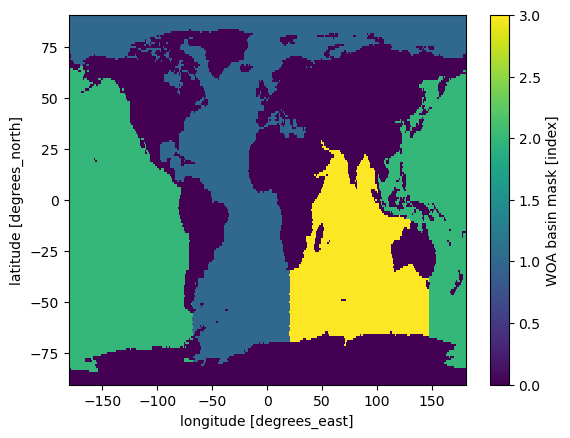

In [34]:
woce_mask_rg.REGION_MASK.plot()

In [35]:
woce_rg = w1regridder_base(woce)

In [36]:
woce_rg

<xarray.Dataset>
Dimensions:   (ZAX: 44, lat: 181, lon: 361)
Coordinates:
  * ZAX       (ZAX) float64 0.0 10.0 20.0 30.0 ... 5.25e+03 5.5e+03 5.75e+03
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables: (12/13)
    BOT_DEP   (ZAX, lat, lon) float32 -3.566e+03 -3.566e+03 ... 4.29e+03
    PRES      (ZAX, lat, lon) float32 0.0 0.0 0.0 ... 5.872e+03 5.872e+03
    TEMP      (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    TPOTEN    (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SALINITY  (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    OXYGEN    (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...        ...
    NITRATE   (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    PHOSPH    (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    GAMMAN    (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SIG0      (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SIG2      (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SIG4      (ZAX, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  nearest_s2d

In [37]:
woce_rg.ZAX

<xarray.DataArray 'ZAX' (ZAX: 44)>
array([   0.,   10.,   20.,   30.,   40.,   50.,   75.,  100.,  125.,  150.,
        175.,  200.,  250.,  300.,  350.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000., 2250.,
       2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750.,
       5000., 5250., 5500., 5750.])
Coordinates:
  * ZAX      (ZAX) float64 0.0 10.0 20.0 30.0 ... 5.25e+03 5.5e+03 5.75e+03

In [38]:
woce_rg.interp(ZAX=bebm_SALT.z_t/100.)

<xarray.Dataset>
Dimensions:   (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
    ZAX       (z_t) float32 5.0 15.0 25.0 35.0 ... 4.875e+03 5.125e+03 5.375e+03
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables: (12/13)
    BOT_DEP   (z_t, lat, lon) float64 -3.566e+03 -3.566e+03 ... 4.29e+03
    PRES      (z_t, lat, lon) float64 5.0 5.0 5.0 ... 5.484e+03 5.484e+03
    TEMP      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    TPOTEN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SALINITY  (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    OXYGEN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ...        ...
    NITRATE   (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    PHOSPH    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    GAMMAN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG0      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG2      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG4      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  nearest_s2d

In [39]:
#woce_rg_z_t_PHOSPH = linear_interpolation_remap(woce_rg.ZAX, woce_rg.PHOSPH, bebm_SALT.z_t)
woce_rg_z_t = woce_rg.interp(ZAX=bebm_SALT.z_t/100.).drop("ZAX")

In [40]:
woce_rg_glo = woce_rg_z_t
woce_rg_atl = woce_rg_z_t.where(woce_mask_rg.REGION_MASK == 1)
woce_rg_pac = woce_rg_z_t.where(woce_mask_rg.REGION_MASK == 2)
woce_rg_ind = woce_rg_z_t.where(woce_mask_rg.REGION_MASK == 3)


In [41]:
woce_rg_glo

<xarray.Dataset>
Dimensions:   (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables: (12/13)
    BOT_DEP   (z_t, lat, lon) float64 -3.566e+03 -3.566e+03 ... 4.29e+03
    PRES      (z_t, lat, lon) float64 5.0 5.0 5.0 ... 5.484e+03 5.484e+03
    TEMP      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    TPOTEN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SALINITY  (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    OXYGEN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ...        ...
    NITRATE   (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    PHOSPH    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    GAMMAN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG0      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG2      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG4      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  nearest_s2d

In [42]:
bebm_SALT

<xarray.Dataset>
Dimensions:  (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    SALT     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [43]:
def set_amazon_grid(ax, labelsize, xon=True, yon=True):
    # Set lat/lon grid 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.bot_labels = xon
    gl.left_labels = yon
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': labelsize}
    gl.ylabel_style = {'size': labelsize} 
    #mext = [290, 360, -25, 25]
    #xext = np.linspace(mext[0],mext[1],8)
    #print(xext)
    #gl.xlocator = mticker.FixedLocator(xext)
    #yext = np.linspace(mext[0],mext[-1],10)
    #gl.ylocator = mticker.FixedLocator([10, 20, 30, 40, 50])

    # Add map features with Cartopy 
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='gray'))
    ax.add_feature(cfeature.RIVERS)                                   
    ax.coastlines(linewidth=1)
    ax.set_facecolor("gray")

def call_vert_cbar(pfig, ax, cx, cy, pl, cbstr, width=0.02):
    pos = ax.get_position()
    l, b, w, h = pos.bounds
    cbarxoffset=cx
    cbaryoffset=cy
    cbax = pfig.add_axes([l+cbarxoffset+w, b+cbaryoffset, width, h]) # setup colorbar axes
    cb=fig.colorbar(pl,cax=cbax, orientation='vertical') # draw colorbar
    cb.set_label(cbstr,y=0.5, size='large', weight='bold')


In [44]:
gebm_3d_vars

<xarray.Dataset>
Dimensions:  (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    TEMP     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SALT     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    UVEL     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    VVEL     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    O2       (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SiO3     (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    NO3      (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    PO4      (z_t, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [45]:
woce_rg_glo

<xarray.Dataset>
Dimensions:   (z_t: 60, lat: 181, lon: 361)
Coordinates:
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables: (12/13)
    BOT_DEP   (z_t, lat, lon) float64 -3.566e+03 -3.566e+03 ... 4.29e+03
    PRES      (z_t, lat, lon) float64 5.0 5.0 5.0 ... 5.484e+03 5.484e+03
    TEMP      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    TPOTEN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SALINITY  (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    OXYGEN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ...        ...
    NITRATE   (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    PHOSPH    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    GAMMAN    (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG0      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG2      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SIG4      (z_t, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  nearest_s2d

In [46]:
woce_rg_glo["TPOTEN"]

<xarray.DataArray 'TPOTEN' (z_t: 60, lat: 181, lon: 361)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.63628948, -1.63513601, -1.63387597, ..., -1.63828951,
         -1.63726252, -1.63628948],
        [-1.622639  , -1.62183851, -1.621185  , ..., -1.624147  ,
         -1.62333304, -1.622639  ],
        [-1.63270998, -1.63270998, -1.63270998, ..., -1.63270998,
         -1.63270998, -1.63270998]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05

In [47]:
def depth_lon_section_uvplot_gcase(lat=0.0, lon1=-90, lon2=30):
    d1=0
    d2=500000
    #def set_scale(axx):
    #    linear_piecewise_scale(50000, 20, ax = axx)
    #    # Rearange the yticks
    #    axx.set_yticks([0, 12500, 25000, 37500, 50000, 200000, 400000, 600000]);
    #    axx.axhline(50000, color='0.5', ls='--')
    def set_scale_obs(axx):
        linear_piecewise_scale(500, 20, ax = axx)
        # Rearange the yticks
        #axx.set_yticks([0, 125, 250, 375, 500, 2000, 4000, 6000]);
        dticks = np.linspace(0,d2,10)
        axx.set_yticks([0, 125, 250, 375, 500, 2000, 4000, 6000]);
        axx.axhline(500, color='0.5', ls='--')
    #def set_scale(axx):
    #    linear_piecewise_scale(50000, 20, ax = axx)
    #    # Rearange the yticks
    #    axx.set_yticks([0.0, 12500., 25000., 37500., 50000., 200000., 400000., 600000.]);
    #    axx.set_yticklabels(["0", "125", "250", "375", "500", "2000", "4000", "6000"]);
    #    axx.axhline(50000, color='0.5', ls='--')
    def set_scale(axx):
        linear_piecewise_scale(50000, 20, ax = axx)
        # Rearange the yticks
        axx.set_yticks([0.0, 12500., 25000., 37500., 50000., 200000., 400000., 600000.]);
        axx.set_yticklabels(["0", "125", "250", "375", "500", "2000", "4000", "6000"]);
        #axx.axhline(50000, color='0.5', ls='--')
        
    #colmap = ocm.cm.haline
    uclevs = np.linspace(-20,20,21)
    udclevs = np.linspace(-2,2,21)
    vclevs = np.linspace(-20,20,21)
    vdclevs = np.linspace(-2,2,21)
    colmap = ocm.cm.delta
    dcolmap = ocm.cm.diff
    
    sclevs = np.linspace(34,38,41)
    sdclevs = np.linspace(-0.5,0.5,21)
    scolmap = ocm.cm.curl
    sdcolmap = ocm.cm.balance
    
    units = gebm_3d_vars["UVEL"].units
    sunits = "psu"
    if lat > 0:
        ns_str="N"
    elif lat <0:
        ns_str="S"
    else:
        ns_str=""
        
    latstr = str(abs(int(lat)))+"$\degree$"+ns_str
    
    fig, axs = plt.subplots(2, 3, figsize=(16,6))
    #colmap = ocm.cm.thermal
    #clevs = np.linspace(0,20,21)

    obs_sect = gebm_3d_vars["UVEL"].sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    obs_p = obs_sect.plot.contourf(ax = axs[0,0], levels=uclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "UVEL ("+units+")"}))
    axs[0,0].set_facecolor('grey')
    axs[0,0].invert_yaxis()
    axs[0,0].set_title("GEBM UVEL: "+latstr)
    
    g_sect = gebm_3d_vars["VVEL"].sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    g_p = g_sect.plot.contourf(ax = axs[0,1], levels=vclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "VVEL ("+units+")"}))
    axs[0,1].set_facecolor('grey')
    axs[0,1].invert_yaxis()
    axs[0,1].set_title("GEBM VVEL: "+latstr)

    g_salt = gebm_3d_vars["SALT"].sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    g_ps = g_salt.plot.contourf(ax = axs[0,2], levels=sclevs,  cmap=scolmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "SALT ("+sunits+")"}))
    axs[0,2].set_facecolor('grey')
    axs[0,2].invert_yaxis()
    axs[0,2].set_title("GEBM SALT: "+latstr)

    #dcolmap = ocm.cm.balance
    #dclevs = np.linspace(-4,4,21)
    geo_sect = (gebm_3d_vars["UVEL"] - gnoebm_3d_vars["UVEL"]).sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    geo_p = geo_sect.plot.contourf(ax = axs[1,0], levels=udclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "UVEL ("+units+")"}))
    axs[1,0].set_facecolor('grey')
    axs[1,0].invert_yaxis()
    axs[1,0].set_title("GEBM - GNOEBM (UVEL): "+latstr)

    gebe_sect = (gebm_3d_vars["VVEL"] - gnoebm_3d_vars["VVEL"]).sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    gebe_p = gebe_sect.plot.contourf(ax = axs[1,1], levels=vdclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "VVEL ("+units+")"}))
    axs[1,1].set_facecolor('grey')
    axs[1,1].invert_yaxis()
    axs[1,1].set_title("GEBM - GNOEBM (VVEL): "+latstr)

    gebe_salt = (gebm_3d_vars["SALT"] - gnoebm_3d_vars["SALT"]).sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    gebe_sp = gebe_salt.plot.contourf(ax = axs[1,2], levels=sdclevs,  cmap=sdcolmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "SALT ("+sunits+")"}))
    axs[1,2].set_facecolor('grey')
    axs[1,2].invert_yaxis()
    axs[1,2].set_title("GEBM - GNOEBM (SALT): "+latstr)


    #axs.set_title('Title')
    #set_scale(axs)

    #for ax in axs.flat:
    #    ax.set(xlabel='Longitude ($^\circ$E)', ylabel='Depth (cm)')
    #    set_scale(ax)
    axs[0,0].set(xlabel='', ylabel='Depth (cm)')
    set_scale(axs[0,0])
    axs[0,1].set(xlabel='', ylabel='Depth (cm)')
    set_scale(axs[0,1])
    axs[0,2].set(xlabel='', ylabel='Depth (cm)')
    set_scale(axs[0,2])
    axs[1,0].set(xlabel='Longitude ($\degree$)', ylabel='Depth (cm)')
    set_scale(axs[1,0])
    axs[1,1].set(xlabel='Longitude ($\degree$)', ylabel='Depth (cm)')
    set_scale(axs[1,1])
    axs[1,2].set(xlabel='Longitude ($\degree$)', ylabel='Depth (cm)')
    set_scale(axs[1,2])

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    #fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
    #                    wspace=0.04, hspace=0.15)
    #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    #cbar = fig.colorbar(gp, cax=cb_ax)
    plt.subplots_adjust(hspace= 0.25, wspace = 0.25)

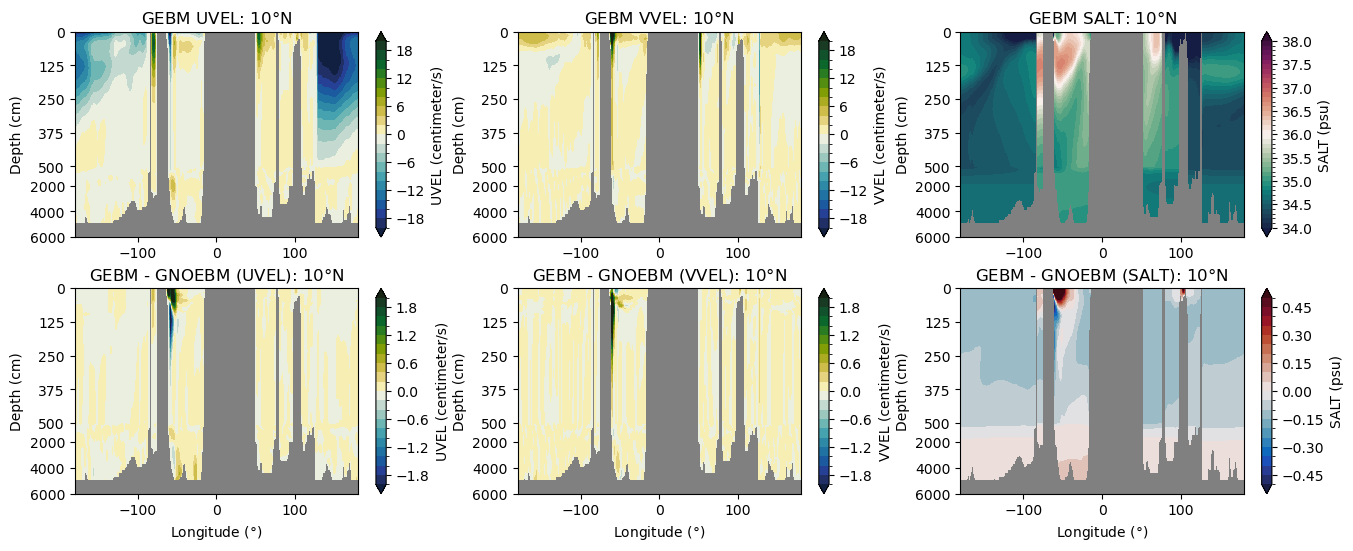

In [48]:
depth_lon_section_uvplot_gcase(10.0, -180., 180.) 

In [49]:
interactive_plot = interactive(depth_lon_section_uvplot_gcase,
                               lat=(-90,90,1),
                               lon1=(-180,180,5),
                               lon2=(-180,180,5),
                              )


output = interactive_plot.children[-1]
#output = interactive_plot.children
output.layout.height = '640px'
interactive_plot

interactive(children=(IntSlider(value=0, description='lat', max=90, min=-90), IntSlider(value=-90, description…

In [50]:
def depth_lon_section_uvplot_bcase(lat=0.0, lon1=-90, lon2=30):
    d1=0
    d2=500000
    #def set_scale(axx):
    #    linear_piecewise_scale(50000, 20, ax = axx)
    #    # Rearange the yticks
    #    axx.set_yticks([0, 12500, 25000, 37500, 50000, 200000, 400000, 600000]);
    #    axx.axhline(50000, color='0.5', ls='--')
    def set_scale_obs(axx):
        linear_piecewise_scale(500, 20, ax = axx)
        # Rearange the yticks
        #axx.set_yticks([0, 125, 250, 375, 500, 2000, 4000, 6000]);
        dticks = np.linspace(0,d2,10)
        axx.set_yticks([0, 125, 250, 375, 500, 2000, 4000, 6000]);
        axx.axhline(500, color='0.5', ls='--')
    #def set_scale(axx):
    #    linear_piecewise_scale(50000, 20, ax = axx)
    #    # Rearange the yticks
    #    axx.set_yticks([0.0, 12500., 25000., 37500., 50000., 200000., 400000., 600000.]);
    #    axx.set_yticklabels(["0", "125", "250", "375", "500", "2000", "4000", "6000"]);
    #    axx.axhline(50000, color='0.5', ls='--')
    def set_scale(axx):
        linear_piecewise_scale(50000, 20, ax = axx)
        # Rearange the yticks
        axx.set_yticks([0.0, 12500., 25000., 37500., 50000., 200000., 400000., 600000.]);
        axx.set_yticklabels(["0", "125", "250", "375", "500", "2000", "4000", "6000"]);
        #axx.axhline(50000, color='0.5', ls='--')
        
    #colmap = ocm.cm.haline
    uclevs = np.linspace(-20,20,21)
    udclevs = np.linspace(-2,2,21)
    vclevs = np.linspace(-20,20,21)
    vdclevs = np.linspace(-2,2,21)
    colmap = ocm.cm.delta
    dcolmap = ocm.cm.diff
    
    sclevs = np.linspace(34,38,41)
    sdclevs = np.linspace(-0.5,0.5,21)
    scolmap = ocm.cm.curl
    sdcolmap = ocm.cm.balance
    
    units = gebm_3d_vars["UVEL"].units
    sunits = "psu"
    if lat > 0:
        ns_str="N"
    elif lat <0:
        ns_str="S"
    else:
        ns_str=""
        
    latstr = str(abs(int(lat)))+"$\degree$"+ns_str
    
    fig, axs = plt.subplots(2, 3, figsize=(16,6))
    #colmap = ocm.cm.thermal
    #clevs = np.linspace(0,20,21)

    obs_sect = bebm_3d_vars["UVEL"].sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    obs_p = obs_sect.plot.contourf(ax = axs[0,0], levels=uclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "UVEL ("+units+")"}))
    axs[0,0].set_facecolor('grey')
    axs[0,0].invert_yaxis()
    axs[0,0].set_title("BEBM UVEL: "+latstr)
    
    g_sect = bebm_3d_vars["VVEL"].sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    g_p = g_sect.plot.contourf(ax = axs[0,1], levels=vclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "VVEL ("+units+")"}))
    axs[0,1].set_facecolor('grey')
    axs[0,1].invert_yaxis()
    axs[0,1].set_title("BEBM VVEL: "+latstr)

    g_salt = bebm_3d_vars["SALT"].sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    g_ps = g_salt.plot.contourf(ax = axs[0,2], levels=sclevs,  cmap=scolmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "SALT ("+sunits+")"}))
    axs[0,2].set_facecolor('grey')
    axs[0,2].invert_yaxis()
    axs[0,2].set_title("BEBM SALT: "+latstr)

    #dcolmap = ocm.cm.balance
    #dclevs = np.linspace(-4,4,21)
    geo_sect = (bebm_3d_vars["UVEL"] - bnoebm_3d_vars["UVEL"]).sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    geo_p = geo_sect.plot.contourf(ax = axs[1,0], levels=udclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "UVEL ("+units+")"}))
    axs[1,0].set_facecolor('grey')
    axs[1,0].invert_yaxis()
    axs[1,0].set_title("BEBM - BNOEBM (UVEL): "+latstr)

    gebe_sect = (bebm_3d_vars["VVEL"] - bnoebm_3d_vars["VVEL"]).sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    gebe_p = gebe_sect.plot.contourf(ax = axs[1,1], levels=vdclevs,  cmap=colmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "VVEL ("+units+")"}))
    axs[1,1].set_facecolor('grey')
    axs[1,1].invert_yaxis()
    axs[1,1].set_title("BEBM - BNOEBM (VVEL): "+latstr)

    gebe_salt = (bebm_3d_vars["SALT"] - bnoebm_3d_vars["SALT"]).sel(lat=lat, method='nearest').sel(lon=slice(lon1,lon2)).sel(z_t=slice(d1,d2))
    #print(obs_sect)
    gebe_sp = gebe_salt.plot.contourf(ax = axs[1,2], levels=sdclevs,  cmap=sdcolmap, extend='both',
                                add_colorbar=True, robust = True, cbar_kwargs = ({"label": "SALT ("+sunits+")"}))
    axs[1,2].set_facecolor('grey')
    axs[1,2].invert_yaxis()
    axs[1,2].set_title("BEBM - BNOEBM (SALT): "+latstr)


    #axs.set_title('Title')
    #set_scale(axs)

    #for ax in axs.flat:
    #    ax.set(xlabel='Longitude ($^\circ$E)', ylabel='Depth (cm)')
    #    set_scale(ax)
    axs[0,0].set(xlabel='', ylabel='Depth (cm)')
    set_scale(axs[0,0])
    axs[0,1].set(xlabel='', ylabel='Depth (cm)')
    set_scale(axs[0,1])
    axs[0,2].set(xlabel='', ylabel='Depth (cm)')
    set_scale(axs[0,2])
    axs[1,0].set(xlabel='Longitude ($\degree$)', ylabel='Depth (cm)')
    set_scale(axs[1,0])
    axs[1,1].set(xlabel='Longitude ($\degree$)', ylabel='Depth (cm)')
    set_scale(axs[1,1])
    axs[1,2].set(xlabel='Longitude ($\degree$)', ylabel='Depth (cm)')
    set_scale(axs[1,2])

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    #fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
    #                    wspace=0.04, hspace=0.15)
    #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    #cbar = fig.colorbar(gp, cax=cb_ax)
    plt.subplots_adjust(hspace= 0.25, wspace = 0.25)

In [51]:
interactive_plot = interactive(depth_lon_section_uvplot_bcase,
                               lat=(-90,90,1),
                               lon1=(-180,180,5),
                               lon2=(-180,180,5),
                              )


output = interactive_plot.children[-1]
#output = interactive_plot.children
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=0, description='lat', max=90, min=-90), IntSlider(value=-90, description…

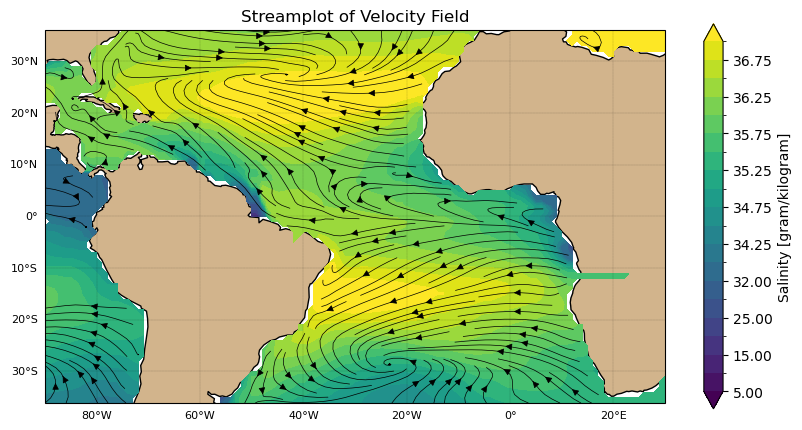

In [52]:
#import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# Your initial setup
zlevel = 0
ulon = gebm_UVEL.lon
ulat = gebm_UVEL.lat
uvel = gebm_UVEL["UVEL"].isel(z_t=zlevel)
vvel = gebm_VVEL["VVEL"].isel(z_t=zlevel)
salt = gebm_SALT["SALT"].isel(z_t=zlevel)
# Choose a Cartopy projection that suits your data
# For example, PlateCarree is a global projection suitable for streaming velocity fields
projection = ccrs.PlateCarree()

# Create a figure with a single axes set with the projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': projection})

# Optional: Define the extent of your plot [min_lon, max_lon, min_lat, max_lat]
# For example, if you know the bounds, you can set them like this:
#ax.set_extent([min(ulon), max(ulon), min(ulat), max(ulat)])
ax.set_extent([-90, 30, -20, 20])

# Add features to the plot, such as land, ocean or coastlines
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='tan') 


# contour salinity under the streamlines
slevs = np.array([5,10,15,20,25,30,32, 34, 34.25, 34.5, 34.75, 35, 35.25, 35.5, 35.75, 36, 36.25, 36.5, 36.75, 37])
salt.plot.contourf(levels = slevs)
# Create the streamplot using the UVEL and VVEL fields
# The transform keyword tells Cartopy what coordinate system your data uses
ax.streamplot(ulon, ulat, uvel, vvel, transform=ccrs.PlateCarree(), color='black', density=2, linewidth=0.5)

# Optional: Use ax.coastlines() if you want to add coastlines
# ax.coastlines()

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Streamplot of Velocity Field')

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 


In [53]:
def stream_plot(zl=0):
    # Use the PlateCarree projection, which is good for global scaled plots.
    projection = ccrs.PlateCarree()
    # Create a figure object and add an axes object with the desired projection.
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(111, projection=projection)
    #ax1 = plt.subplot(222, projection=projection)
    #ax2 = plt.subplot(223, projection=projection)
    #ax3 = plt.subplot(224, projection=projection)

    # Your initial setup
    zlevel = zl
    ulon = gebm_UVEL.lon
    ulat = gebm_UVEL.lat
    uvel = gebm_UVEL["UVEL"].isel(z_t=zlevel)
    vvel = gebm_VVEL["VVEL"].isel(z_t=zlevel)
    salt = gebm_SALT["SALT"].isel(z_t=zlevel)
    # Choose a Cartopy projection that suits your data
    # For example, PlateCarree is a global projection suitable for streaming velocity fields
    projection = ccrs.PlateCarree()
    
    # Create a figure with a single axes set with the projection
    #fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': projection})
    
    # Optional: Define the extent of your plot [min_lon, max_lon, min_lat, max_lat]
    # For example, if you know the bounds, you can set them like this:
    #ax.set_extent([min(ulon), max(ulon), min(ulat), max(ulat)])
    ax.set_extent([-90, 30, -20, 20])
    
    # Add features to the plot, such as land, ocean or coastlines
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='tan') 
    
    
    # contour salinity under the streamlines
    slevs = np.array([5,10,15,20,25,30,32, 34, 34.25, 34.5, 34.75, 35, 35.25, 35.5, 35.75, 36, 36.25, 36.5, 36.75, 37])
    salt.plot.contourf(levels = slevs, extend='both')
    # Create the streamplot using the UVEL and VVEL fields
    # The transform keyword tells Cartopy what coordinate system your data uses
    ax.streamplot(ulon, ulat, uvel, vvel, transform=ccrs.PlateCarree(), color='black', density=2, linewidth=0.5)
    
    # Optional: Use ax.coastlines() if you want to add coastlines
    # ax.coastlines()
    
    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Streamplot of Velocity Field ('+str(gebm_SALT.z_t.isel(z_t=zl).values/100.)+" meters)")
    
    # Plot lat/lon grid 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8} 


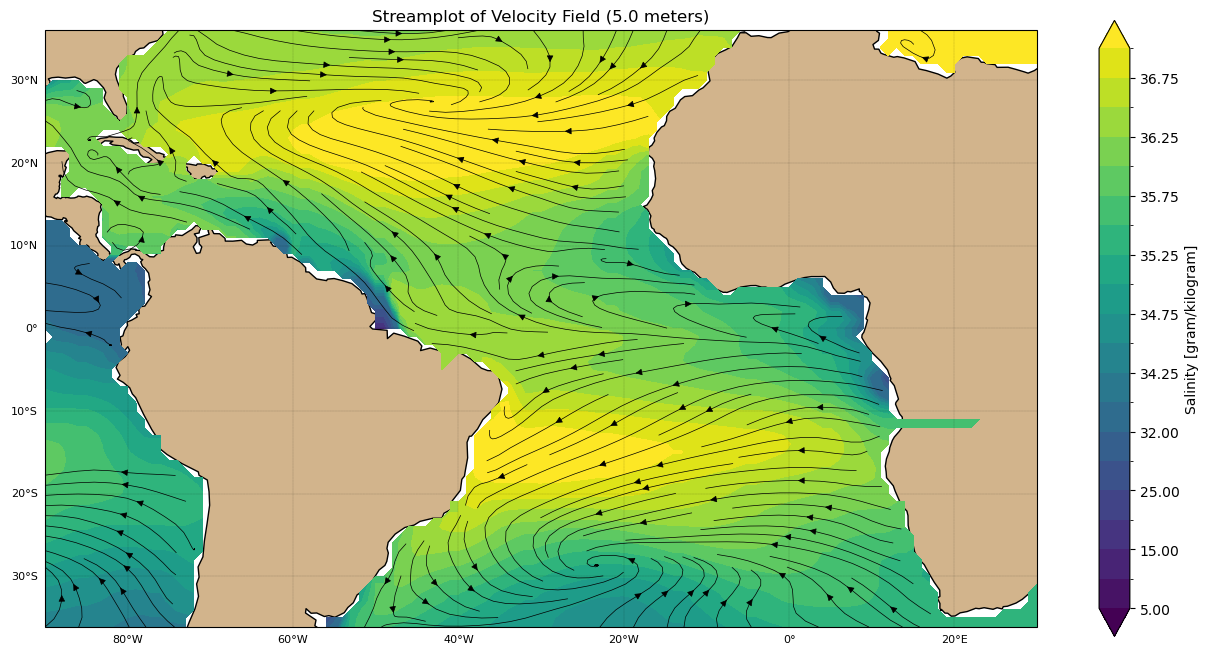

In [54]:
stream_plot(0)

In [55]:
zinteractive_plot = interactive(stream_plot,
                               zl=(0,59,1),
                              )


output = zinteractive_plot.children[-1]
#output = interactive_plot.children
output.layout.height = '640px'
zinteractive_plot

interactive(children=(IntSlider(value=0, description='zl', max=59), Output(layout=Layout(height='640px'))), _d…

In [56]:
# load up regrided data and look at runoff
bebm_ann_file_rg = xr.open_dataset("/mdata/climo/B1850_BPRP_f19_g17_ref//ocn/B1850_BPRP_f19_g17_ref_ANN_051912_056911_climo_rgr.nc", engine="netcdf4").squeeze()
bnoebm_ann_file_rg = xr.open_dataset("/mdata/climo/B1850_BPRP_f19_g17_noest/ocn/B1850_BPRP_f19_g17_noest_ANN_051912_056911_climo_rgr.nc", engine="netcdf4").squeeze()

In [57]:
gebm_ann_file_rg = xr.open_dataset("/mdata/climo/g1850ecoctrl1deg/ocn/g1850ecoctrl1deg_ANN_051912_056911_climo_rgr.nc", engine="netcdf4").squeeze()
gnoebm_ann_file_rg = xr.open_dataset("/mdata/climo/g1850econoest1deg/ocn/g1850econoest1deg_ANN_051912_056911_climo_rgr.nc", engine="netcdf4").squeeze()


In [58]:
bebm_ann_file_rg.ROFF_F

<xarray.DataArray 'ROFF_F' (nlat: 96, nlon: 144)>
[13824 values with dtype=float32]
Coordinates:
    time     object 0519-12-15 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:      Runoff Flux from Coupler
    units:          kg/m^2/s
    grid_loc:       2110
    cell_methods:   time: mean within years time: mean over years
    cell_measures:  area: area

In [59]:
bebm_ROFF

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    ROFF_F   (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

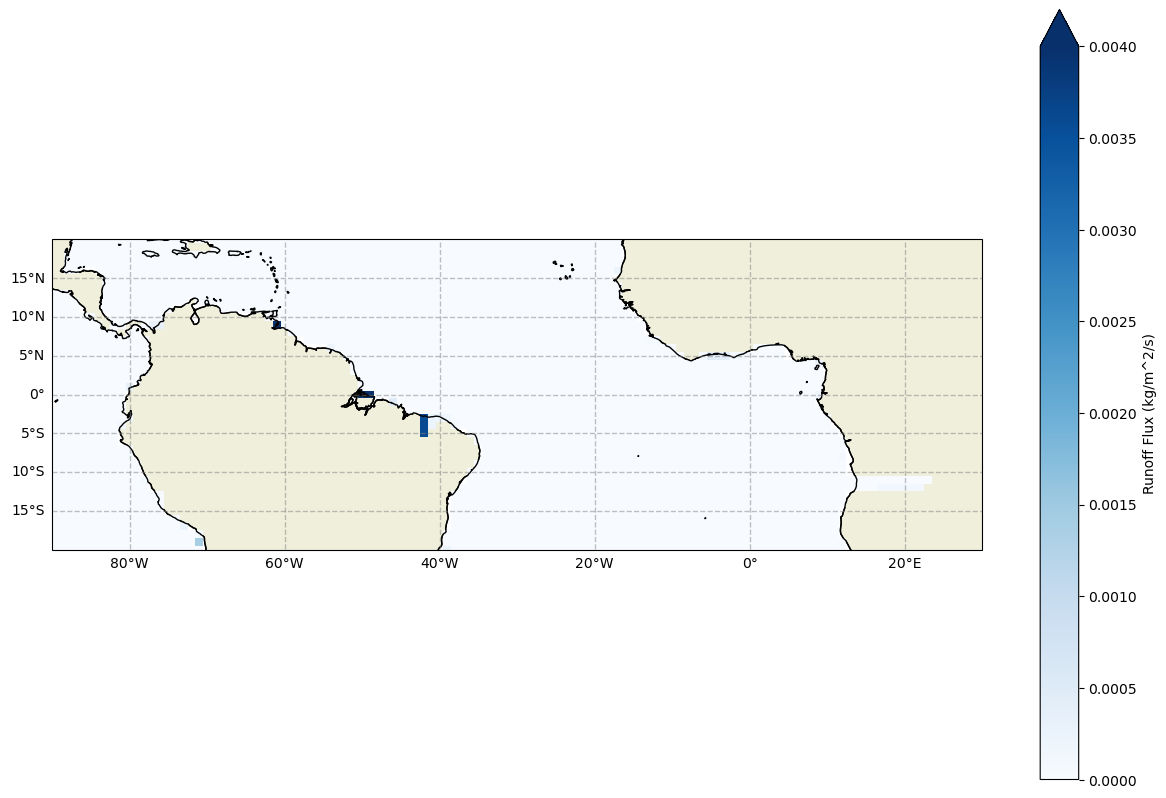

In [60]:
# Use the PlateCarree projection, which is good for global scaled plots.
projection = ccrs.PlateCarree()

# Create a figure object and add an axes object with the desired projection.
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': projection})

# Set extent could be used if you want to zoom into a specific region.
ax.set_extent([-90, 30, -20, 20], crs=ccrs.PlateCarree())

# Add features to the map from Cartopy's built-in feature interface.
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')

# Define the colormap
cmap = plt.cm.Blues

# Plotting the data
# If the latitude and longitude coordinates are named differently, replace 'nlat'/'nlon' with the correct names.
# If your data has explicit latitude/longitude coordinates as DataArrays, e.g., lats and lons, you can use them in the pcolormesh call.
# You might need to squeeze out the time dimension if you have a singleton time dimension, as suggested by your coordinate output.
pcm = ax.pcolormesh(bebm_ROFF['lon'], bebm_ROFF['lat'], bebm_ROFF.ROFF_F, 
                    transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')

# Set the colorbar to respect your limits of 0 to 0.004 kg/m^2/s
pcm.set_clim(0, 0.004)

# Add colorbar
plt.colorbar(pcm, ax=ax, extend='max', orientation='vertical', label='Runoff Flux (kg/m^2/s)')

# Adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Show the plot
plt.show()


In [193]:
gebm_ROFF_ocn = climoloader(basedir, gcase_ebm, "ocn", "ROFF_F", sequence).squeeze()  # for 4-D var
gnoebm_ROFF_ocn = climoloader(basedir, gcase_noebm, "ocn", "ROFF_F", sequence).squeeze()
# Set values to zero where nlat is between 0 and 40, to get rid of Antarcitca rivers
maxnlat = 32
gebm_ROFF_ocn = gebm_ROFF_ocn.where(~((gebm_ROFF_ocn.nlat >= 0) & (gebm_ROFF_ocn.nlat <= maxnlat)), 0)
gnoebm_ROFF_ocn = gnoebm_ROFF_ocn.where(~((gnoebm_ROFF_ocn.nlat >= 0) & (gnoebm_ROFF_ocn.nlat <= maxnlat)), 0)
gdiff_ROFF_ocn = gebm_ROFF_ocn - gnoebm_ROFF_ocn

bebm_ROFF_ocn = climoloader(basedir, bcase_ebm, "ocn", "ROFF_F", sequence).squeeze()  # for 4-D var
bnoebm_ROFF_ocn = climoloader(basedir, bcase_noebm, "ocn", "ROFF_F", sequence).squeeze()
# Set values to zero where nlat is between 0 and 40
maxnlat = 32
bebm_ROFF_ocn = bebm_ROFF_ocn.where(~((bebm_ROFF_ocn.nlat >= 0) & (bebm_ROFF_ocn.nlat <= maxnlat)), 0)
bnoebm_ROFF_ocn = bnoebm_ROFF_ocn.where(~((bnoebm_ROFF_ocn.nlat >= 0) & (bnoebm_ROFF_ocn.nlat <= maxnlat)), 0)
bdiff_ROFF_ocn = bebm_ROFF_ocn - bnoebm_ROFF_ocn

# need to set Antarctic data to zero

# Assuming ds is your xarray Dataset and 'ROFF_F' is the DataArray you want to modify
# Also assuming 'nlat' is a coordinate in your Dataset



In [194]:
gebm_ROFF_ocn

<xarray.DataArray 'ROFF_F' (nlat: 384, nlon: 320)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     object 0519-12-15 00:00:00
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Runoff Flux from Coupler
    units:         kg/m^2/s
    grid_loc:      2110
    cell_methods:  time: mean within years time: mean over years

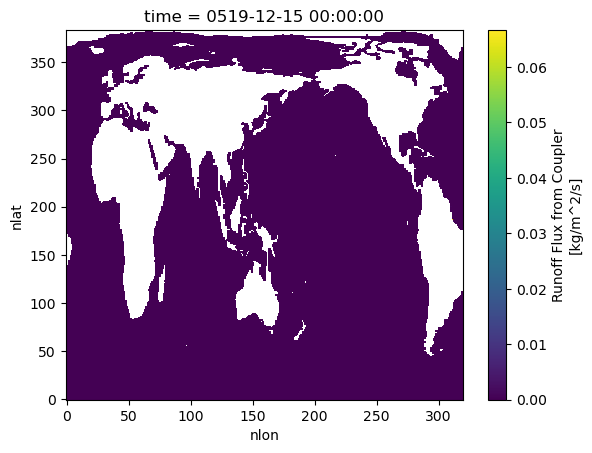

In [195]:
gebm_ROFF_ocn.plot()

/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


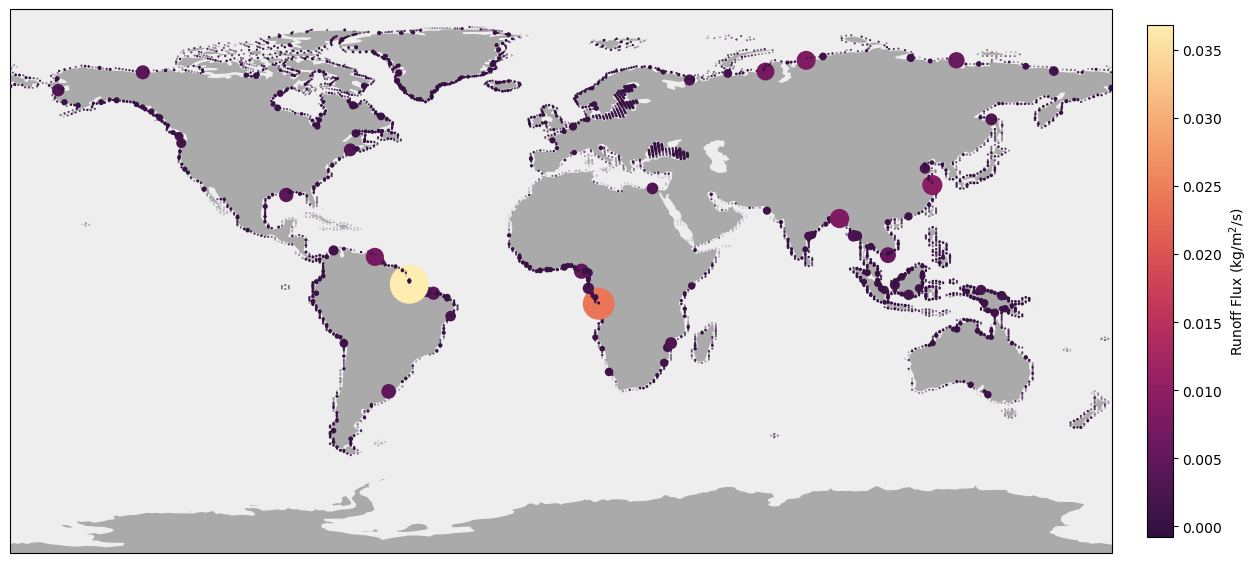

In [196]:
# Use the PlateCarree projection, which is good for global scaled plots.
projection = ccrs.PlateCarree()
# Create a figure object and add an axes object with the desired projection.
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': projection})
#woce_mask_rg.REGION_MASK.where(woce_mask_rg.REGION_MASK == 0).plot(cmap=plt.cm.bwr, add_colorbar=False)
# Add features to the map from Cartopy's built-in feature interface.
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
ax.add_feature(cfeature.OCEAN, color='#eeeeee', edgecolor=None)
# Define the colormap
cmap = plt.cm.Blues

#bebm_ROFF_ocn.plot(ax =ax)
# The ROFF_F values will determine the size of the scatter plot points
# We apply some scaling factor to make the size differences visible
data = bebm_ROFF_ocn.values
# Normalize the size of the scatter points
csize = (data / np.max(data)) # Size scaling for color, assumes data is always positive


scaling_factor = 20000.0
sizes = bebm_ROFF_ocn.values * scaling_factor  # scaling_factor depends on your data range and preference

scatter = ax.scatter(bebm_ROFF_ocn["TLONG"], bebm_ROFF_ocn["TLAT"], s=sizes, c=data, cmap=ocm.cm.matter_r, alpha=1.0, zorder = 10)

# Set the colorbar to respect your limits of 0 to 0.004 kg/m^2/s
pcm.set_clim(0, 0.004)


# Add colorbar
#plt.colorbar(pcm, ax=ax, extend='max', orientation='vertical', label='Runoff Flux (kg/m^2/s)')
# Add a colorbar with a label.
cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label('Runoff Flux (kg/m$^2$/s)')
#cbar.ax.set_yticklabels(['{:.3f}'.format(i) for i in cbar.get_ticks()]) # assuming the range is small



In [197]:
np.nanmin(data)
np.nanmax(data)

0.036802664

/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


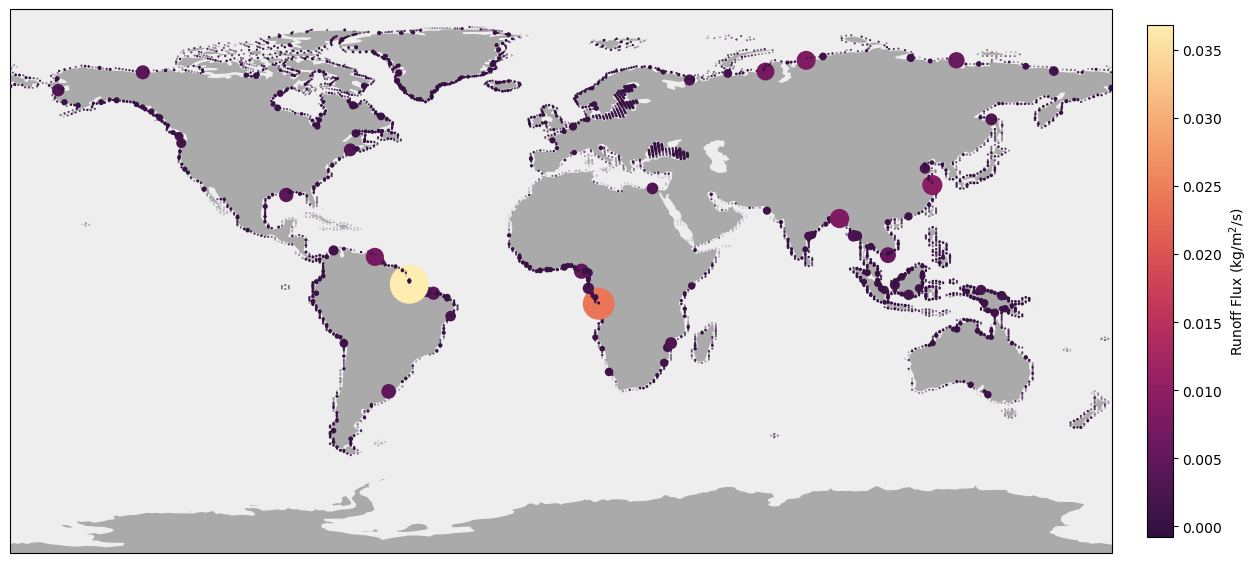

In [198]:
# Use the PlateCarree projection, which is good for global scaled plots.
projection = ccrs.PlateCarree()
# Create a figure object and add an axes object with the desired projection.
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': projection})
#woce_mask_rg.REGION_MASK.where(woce_mask_rg.REGION_MASK == 0).plot(cmap=plt.cm.bwr, add_colorbar=False)
# Add features to the map from Cartopy's built-in feature interface.
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
ax.add_feature(cfeature.OCEAN, color='#eeeeee', edgecolor=None)
# Define the colormap
cmap = plt.cm.Blues

#bebm_ROFF_ocn.plot(ax =ax)
# The ROFF_F values will determine the size of the scatter plot points
# We apply some scaling factor to make the size differences visible
data = bebm_ROFF_ocn.values
# Normalize the size of the scatter points
csize = (data / np.max(data)) # Size scaling for color, assumes data is always positive


scaling_factor = 20000.0
sizes = bebm_ROFF_ocn.values * scaling_factor  # scaling_factor depends on your data range and preference

scatter = ax.scatter(bebm_ROFF_ocn["TLONG"], bebm_ROFF_ocn["TLAT"], s=sizes, c=data, cmap=ocm.cm.matter_r, alpha=1.0, zorder = 10)

# Set the colorbar to respect your limits of 0 to 0.004 kg/m^2/s
pcm.set_clim(0, 0.004)


# Add colorbar
#plt.colorbar(pcm, ax=ax, extend='max', orientation='vertical', label='Runoff Flux (kg/m^2/s)')
# Add a colorbar with a label.
cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label('Runoff Flux (kg/m$^2$/s)')
#cbar.ax.set_yticklabels(['{:.3f}'.format(i) for i in cbar.get_ticks()]) # assuming the range is small


/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/si

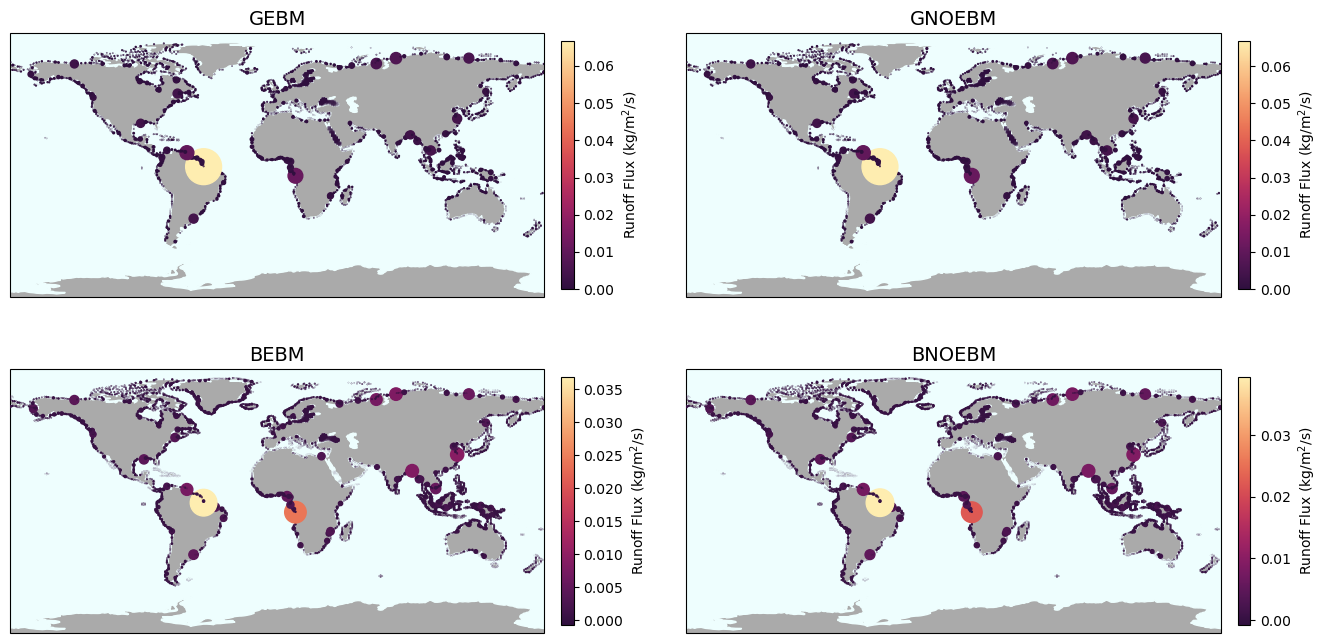

In [199]:
# Use the PlateCarree projection, which is good for global scaled plots.
projection = ccrs.PlateCarree()
# Create a figure object and add an axes object with the desired projection.
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(221, projection=projection)
ax1 = plt.subplot(222, projection=projection)
ax2 = plt.subplot(223, projection=projection)
ax3 = plt.subplot(224, projection=projection)

def plot_rivers(ax, gbdata, title):
    # either
    #woce_mask_rg.REGION_MASK.where(woce_mask_rg.REGION_MASK == 0).plot(cmap=plt.cm.bwr, add_colorbar=False)
    # or
    ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
    ax.add_feature(cfeature.OCEAN, color='#eefefe', edgecolor=None)
    # Define the colormap
    cmap = plt.cm.Blues
    # The ROFF_F values will determine the size of the scatter plot points
    # We apply some scaling factor to make the size differences visible
    data = gbdata.values
    # Normalize the size of the scatter points
    csize = (data / np.max(data)) # Size scaling for color, assumes data is always positive
    
    
    scaling_factor = 10000.0
    sizes = gbdata.values * scaling_factor  # scaling_factor depends on your data range and preference
    
    scatter = ax.scatter(gbdata["TLONG"], gbdata["TLAT"], s=sizes, c=data, cmap=ocm.cm.matter_r, alpha=1.0, zorder = 10)
    
    # Set the colorbar to respect your limits of 0 to 0.004 kg/m^2/s
    pcm.set_clim(0, 0.004)
    
    
    # Add colorbar
    #plt.colorbar(pcm, ax=ax, extend='max', orientation='vertical', label='Runoff Flux (kg/m^2/s)')
    # Add a colorbar with a label.
    cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
    cbar.set_label('Runoff Flux (kg/m$^2$/s)')
    ax.set_title(title, size=14)

plot_rivers(ax0, gebm_ROFF_ocn, "GEBM")
plot_rivers(ax1, gnoebm_ROFF_ocn, "GNOEBM")
plot_rivers(ax2, bebm_ROFF_ocn, "BEBM")
plot_rivers(ax3, bnoebm_ROFF_ocn, "BNOEBM")

In [200]:
#	float S_FLUX_ROFF_VSF_SRF(time, nlat, nlon) ;
#		S_FLUX_ROFF_VSF_SRF:long_name = "Surface Salt Virtual Salt Flux Associated with Rivers" ;
#		S_FLUX_ROFF_VSF_SRF:units = "g/kg*cm/s" ;

#	float T_FLUX_EXCH_INTRF(time, nlat, nlon) ;
#		T_FLUX_EXCH_INTRF:long_name = "Vertical Temperature Flux Across Upper/Lower Layer Interface (From EBM)" ;
#		T_FLUX_EXCH_INTRF:units = "degC*cm/s" ;

#	float S_FLUX_EXCH_INTRF(time, nlat, nlon) ;
#		S_FLUX_EXCH_INTRF:long_name = "Vertical Salt Flux Across Upper/Lower Layer Interface (FromEBM)" ;
#		S_FLUX_EXCH_INTRF:units = "g/kg*cm/s" ;

bcase_vsf_srf = climoloader(basedir, bcase_ebm, "ocn", "S_FLUX_ROFF_VSF_SRF", sequence).squeeze()

In [201]:
bcase_vsf_srf

<xarray.DataArray 'S_FLUX_ROFF_VSF_SRF' (nlat: 384, nlon: 320)>
[122880 values with dtype=float32]
Coordinates:
    time     object 0519-12-15 00:00:00
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Surface Salt Virtual Salt Flux Associated with Rivers
    units:         g/kg*cm/s
    grid_loc:      2110
    cell_methods:  time: mean within years time: mean over years

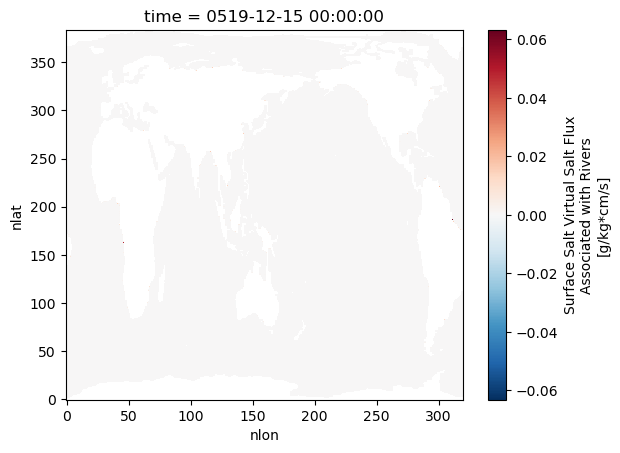

In [202]:
bcase_vsf_srf.plot()

In [203]:
bcase_vsf_srf.max()

<xarray.DataArray 'S_FLUX_ROFF_VSF_SRF' ()>
array(0.06315418)
Coordinates:
    time     object 0519-12-15 00:00:00

In [204]:
riv_obs = xr.open_dataset("obsdata/runoff.daitren.annual.20190226.nc", engine='netcdf4')

In [205]:
riv_obs

<xarray.Dataset>
Dimensions:  (nj: 180, ni: 360, nv: 4, nt: 2)
Dimensions without coordinates: nj, ni, nv, nt
Data variables:
    xc       (nj, ni) float64 ...
    yc       (nj, ni) float64 ...
    xv       (nv, nj, ni) float64 ...
    yv       (nv, nj, ni) float64 ...
    mask     (nj, ni) int16 ...
    area     (nj, ni) float64 ...
    time     (nt) object ...
    runoff   (nt, nj, ni) float64 ...
    rEarth   float64 ...
Attributes:
    title:            Dai_Trenberth Continental Freshwater Discharge
    reference:        Dai, A., and K.E. Trenberth, 2002: Estimates of freshwa...
    created_with:     /glade/work/altuntas/cesm.input/rof/create_dlndstream_d...
    grid:             Global 1x1
    time_dependence:  Annual Mean Climatology (Dai and Trenberth 2002)
    created_by:       Stephen Yeager
    edit:             fixed area and runoff units. -altuntas.

In [206]:
(riv_obs.runoff[1,:,:] -  riv_obs.runoff[0,:,:]).min()

<xarray.DataArray 'runoff' ()>
array(0.)

In [207]:
riv_obs_log = np.log(riv_obs.runoff[0,:,:])

/home/guido/miniforge3/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


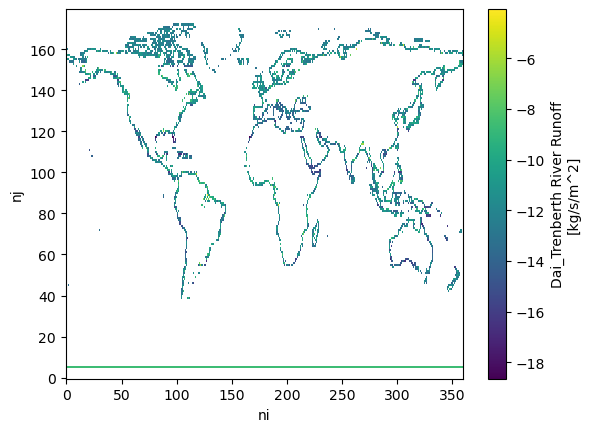

In [208]:
riv_obs_log.plot()

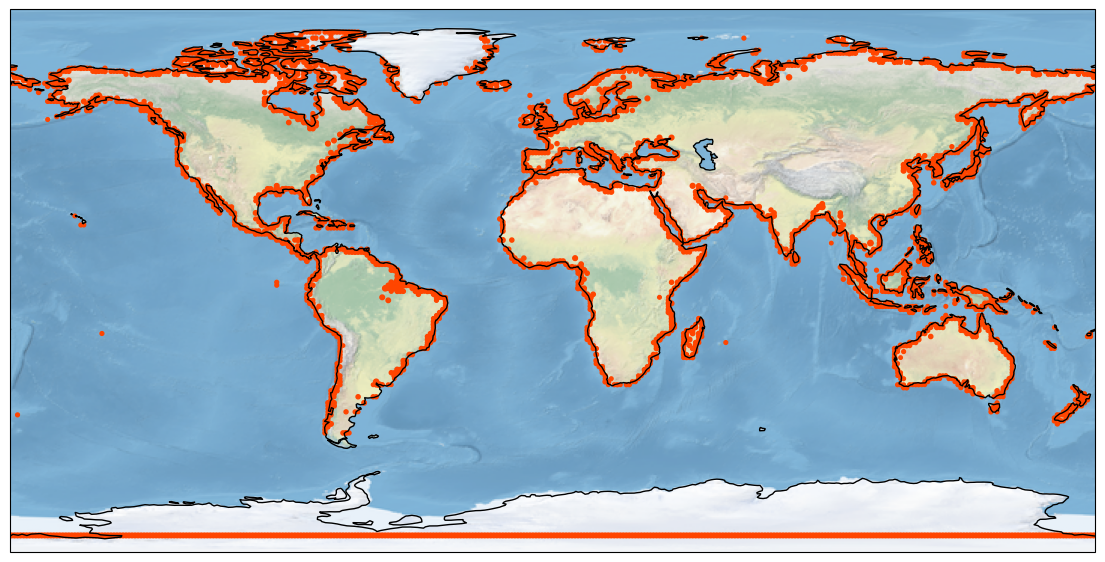

In [209]:
fig = plt.figure(figsize=(14,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.stock_img()
ax.coastlines()

ax.scatter(riv_obs.xc,riv_obs.yc, color="orangered", s=100/-riv_obs_log)
#ax.scatter(years, Brazil, 
#                  c=c_br,
#                 alpha=0.5,
#                 s = b_normal * 2000)
#plt.scatter(years, Ireland, 
#                  c=c_fr,
#                 alpha=0.5,
#                 s = i_normal * 2000,
#                 )
#plt.xlabel("Years", size=14)
#plt.ylabel("Number of immigrants", size=14)

In [210]:
riv_obs.runoff.isel(nt=0).values.min()

0.0

In [211]:
riv_obs.runoff

<xarray.DataArray 'runoff' (nt: 2, nj: 180, ni: 360)>
[129600 values with dtype=float64]
Dimensions without coordinates: nt, nj, ni
Attributes:
    long_name:  Dai_Trenberth River Runoff
    units:      kg/s/m^2

In [212]:
riv_obs

<xarray.Dataset>
Dimensions:  (nj: 180, ni: 360, nv: 4, nt: 2)
Dimensions without coordinates: nj, ni, nv, nt
Data variables:
    xc       (nj, ni) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    yc       (nj, ni) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    xv       (nv, nj, ni) float64 ...
    yv       (nv, nj, ni) float64 ...
    mask     (nj, ni) int16 ...
    area     (nj, ni) float64 ...
    time     (nt) object ...
    runoff   (nt, nj, ni) float64 ...
    rEarth   float64 ...
Attributes:
    title:            Dai_Trenberth Continental Freshwater Discharge
    reference:        Dai, A., and K.E. Trenberth, 2002: Estimates of freshwa...
    created_with:     /glade/work/altuntas/cesm.input/rof/create_dlndstream_d...
    grid:             Global 1x1
    time_dependence:  Annual Mean Climatology (Dai and Trenberth 2002)
    created_by:       Stephen Yeager
    edit:             fixed area and runoff units. -altuntas.

In [213]:
rivrunoff = riv_obs.runoff.isel(nt=0)
largerivers = rivrunoff.where(rivrunoff > 0.001)

In [214]:
print(largerivers.min())
print(largerivers.max())


<xarray.DataArray 'runoff' ()>
array(0.00105052)
<xarray.DataArray 'runoff' ()>
array(0.01711656)


/home/guido/miniforge3/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


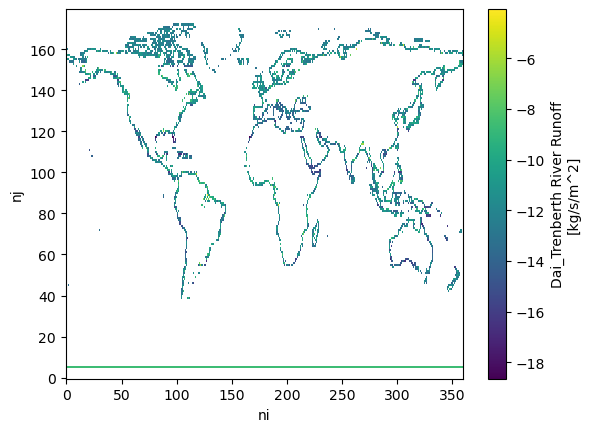

In [215]:
np.log(rivrunoff).plot()

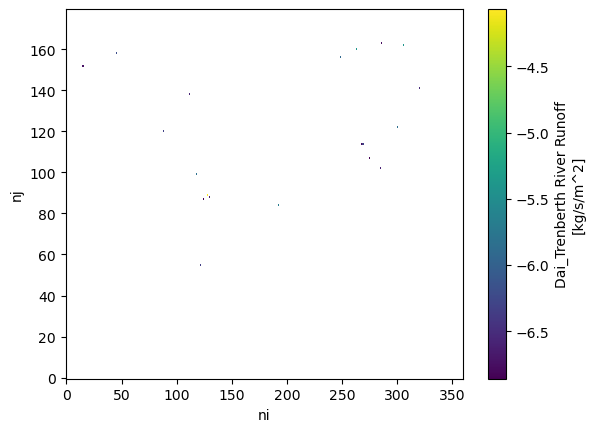

In [216]:
np.log(largerivers).plot()

In [217]:
print(largerivers.max())
print(largerivers.min())

<xarray.DataArray 'runoff' ()>
array(0.01711656)
<xarray.DataArray 'runoff' ()>
array(0.00105052)


In [218]:
largerivers

<xarray.DataArray 'runoff' (nj: 180, ni: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  Dai_Trenberth River Runoff
    units:      kg/s/m^2

In [219]:
largerivers.count(dim=('ni', 'nj'))

<xarray.DataArray 'runoff' ()>
array(20)

In [220]:
xpos = riv_obs.xc.where(largerivers >0.001)
ypos = riv_obs.yc.where(largerivers >0.001)

In [221]:
xpos

<xarray.DataArray 'xc' (nj: 180, ni: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  longitude
    units:      degrees

In [222]:
## how do you make a pandas dataframe from the non-NaN elements in a 2D xarray array 


In [223]:
xpos.count(dim=('ni', 'nj'))

<xarray.DataArray 'xc' ()>
array(20)

In [224]:
xpos

<xarray.DataArray 'xc' (nj: 180, ni: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  longitude
    units:      degrees

In [225]:
non_nan_rivdata = largerivers.values[np.isfinite(largerivers.values)]
non_nan_rivx = xpos.values[np.isfinite(xpos.values)]
non_nan_rivy = ypos.values[np.isfinite(ypos.values)]

rivdf = pd.DataFrame(data=dict(x=non_nan_rivx, y=non_nan_rivy, largerivers=non_nan_rivdata)) 


In [226]:
non_nan_rivy

array([-34.5,  -5.5,  -2.5,  -1.5,  -0.5,   9.5,  12.5,  17.5,  24.5,
        24.5,  30.5,  32.5,  48.5,  51.5,  62.5,  66.5,  68.5,  70.5,
        72.5,  73.5])

In [227]:
non_nan_rivdata

array([0.00176737, 0.00336613, 0.00106812, 0.00132846, 0.01711656,
       0.0029281 , 0.00137161, 0.00105052, 0.00113056, 0.00175969,
       0.00181584, 0.00289167, 0.00140313, 0.00148023, 0.00119476,
       0.00265781, 0.00202672, 0.00460348, 0.00452568, 0.00116095])

In [228]:
rivdf.sort_values(by='largerivers')

x     y  largerivers
7    95.5  17.5     0.001051
2   -55.5  -2.5     0.001068
8    88.5  24.5     0.001131
19  106.5  73.5     0.001161
14 -164.5  62.5     0.001195
3   -49.5  -1.5     0.001328
6   105.5  12.5     0.001372
12  -67.5  48.5     0.001403
13  140.5  51.5     0.001480
9    89.5  24.5     0.001760
0   -57.5 -34.5     0.001767
10  -91.5  30.5     0.001816
16 -134.5  68.5     0.002027
15   69.5  66.5     0.002658
11  120.5  32.5     0.002892
5   -61.5   9.5     0.002928
1    12.5  -5.5     0.003366
18  126.5  72.5     0.004526
17   83.5  70.5     0.004603
4   -51.5  -0.5     0.017117

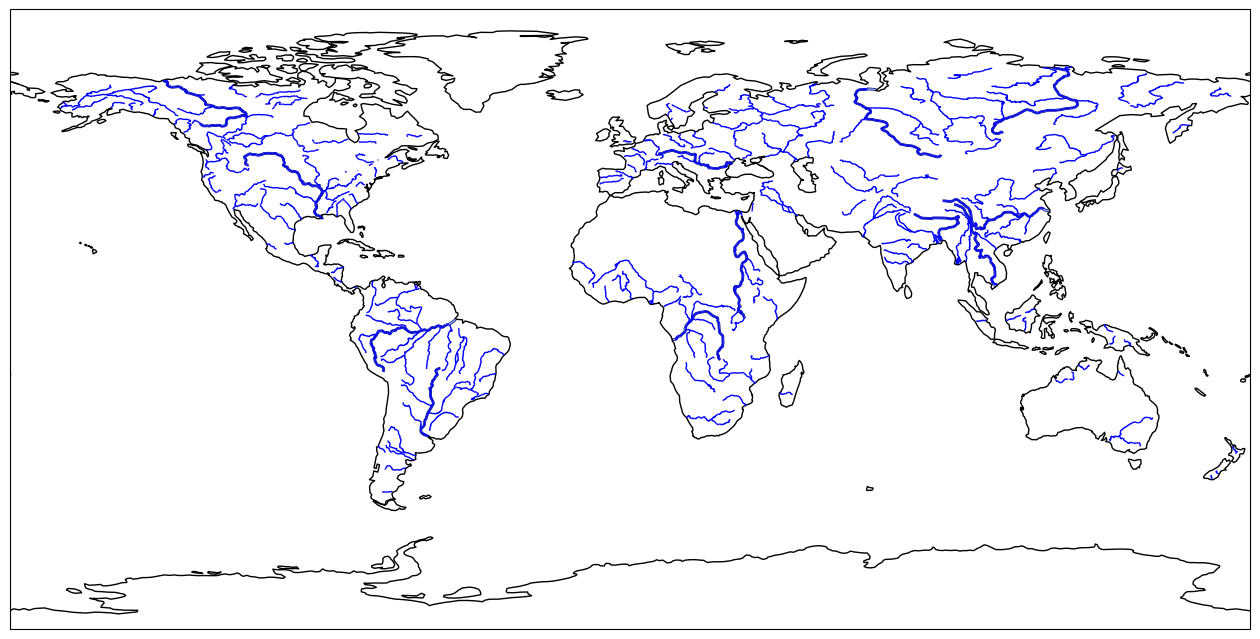

In [229]:
water_color='blue'
fig=plt.figure(figsize=(16,10))
#ax = plt.subplot(111, projection=ccrs.Robinson())
ax = plt.subplot(111, projection=ccrs.PlateCarree())
#ax.set_global()

#ax.add_feature(cfeature.COASTLINE, edgecolor="black")
#ax.add_feature(cfeature.BORDERS, edgecolor="brown")
ax.add_feature(cfeature.RIVERS, edgecolor="darkblue", linewidth=2.0)
#ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                            edgecolor='k', 
#                                            facecolor='gray'), zorder=0)
ax.add_feature(cfeature.RIVERS)                                   
ax.coastlines(linewidth=1)
shp_path = cc.io.shapereader.natural_earth(
        resolution='50m',
        category='physical',
        name='rivers_lake_centerlines')
shp_contents = cc.io.shapereader.Reader(shp_path)
river_generator = shp_contents.geometries()
river_feature = cc.feature.ShapelyFeature(
        river_generator,
        cc.crs.PlateCarree(),
        edgecolor=water_color,
        facecolor='none')
ax.add_feature(river_feature)

180
20
[0.0010505188893509894, 0.004263726904489673, 0.007476934919628355, 0.010690142934767038, 0.013903350949905722]


/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


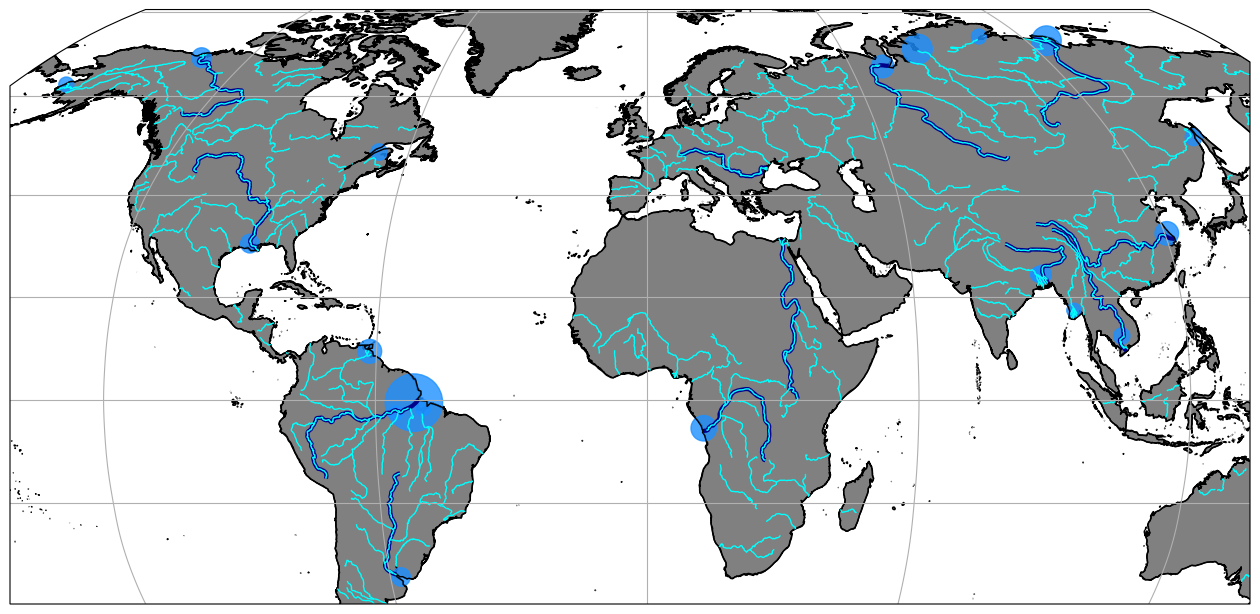

In [230]:
#cutoff kg/s/m^2
cutoff = 0.001
rivrunoff = riv_obs.runoff.isel(nt=0)
largerivers = rivrunoff.where(rivrunoff.values > cutoff)
xpos = riv_obs.xc.where(largerivers > cutoff)
ypos = riv_obs.yc.where(largerivers > cutoff)
print(len(largerivers.values))
M = 5 # Number of bins

water_color='cyan'
water_color_main='darkblue'

non_nan_rivdata = largerivers.values[np.isfinite(largerivers.values)]
non_nan_rivx = xpos.values[np.isfinite(xpos.values)]
non_nan_rivy = ypos.values[np.isfinite(ypos.values)]

rivdf = pd.DataFrame(data=dict(x=non_nan_rivx, y=non_nan_rivy, largerivers=non_nan_rivdata)) 
N=rivdf.shape[0] # number of big rivers
print(N)
# Create the DataFrame from your randomised data and bin it using groupby.
#df = pd.DataFrame(data=dict(x=xpos, y=ypos, largerivers=largerivers))
bins = np.linspace(rivdf.largerivers.min(), rivdf.largerivers.max(), M)
grouped = rivdf.groupby(np.digitize(rivdf.largerivers, bins))

fig=plt.figure(figsize=(16,10))
ax = plt.subplot(111, projection=ccrs.Robinson())
#ax = plt.subplot(111, projection=ccrs.PlateCarree())
#ax.set_global()

#ax.add_feature(cfeature.COASTLINE, edgecolor="black")
#ax.add_feature(cfeature.BORDERS, edgecolor="brown")
#ax.add_feature(cfeature.RIVERS, edgecolor="blue")
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='k', 
                                            facecolor='gray'), zorder=0)
ax.add_feature(cfeature.RIVERS, color=water_color_main, edgecolor=water_color_main, linewidth=3.0)                                   
ax.coastlines(linewidth=1)

# add higher resolution rivers
shp_path = cc.io.shapereader.natural_earth(
        resolution='50m',
        category='physical',
        name='rivers_lake_centerlines')
shp_contents = cc.io.shapereader.Reader(shp_path)
river_generator = shp_contents.geometries()
river_feature = cc.feature.ShapelyFeature(
        river_generator,
        cc.crs.PlateCarree(),
        edgecolor=water_color,
        facecolor='none')
ax.add_feature(river_feature)


#ax.set_facecolor("gray")
ax.gridlines()
#ax.set_extent(
#ax.scatter(riv_obs.xc, riv_obs.yc, largerivers)

largemin = rivdf.largerivers.min()
largemax = rivdf.largerivers.max()
# Create some sizes and some labels.
rivdel = (largemax-largemin)/M
sizes = [largemin+i*rivdel for i in range(M)]
print(sizes)
labels = [ str(np.round(sizes[i],1)) for i in range(M)]

#for i, (name, group) in enumerate(grouped):
#    print(i)
#    print(name)
#    print(group.x)
#    ax.scatter(group.x, group.y, s=sizes[i]*100000, alpha=0.8, label=labels[i], transform=ccrs.PlateCarree() )

#ax.legend()


scatp = ax.scatter(x=xpos, y=ypos,
            color="dodgerblue",
            s=largerivers*100000,
            alpha=0.8,
            transform=ccrs.PlateCarree()) ## Important

#plt.legend(*scatp.legend_elements("sizes", num=6))

# Create the legend handles and labels
#handles, labels = scatp.legend_elements(prop="sizes", num=6)
#print(handles, labels)
#labels = [f"{size}" for size in labels]  # Convert sizes to string labels

# Create the legend with custom circles
#legend = ax.legend(handles, labels, loc="upper left", title="River Runoff\n(kg m$^{-2}$ s$^{-1}$)")
#for handle in legend.legendHandles:
#    handle.set_sizes([50])

icepaperdir="/home/guido/Dropbox/plots/estuaries/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"Figure_rivermap.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure_rivermap.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


In [231]:
! ls /home/guido/Dropbox/ipynb/estuary/ne_50m_rivers_lake_centerlines.shp

/home/guido/Dropbox/ipynb/estuary/ne_50m_rivers_lake_centerlines.shp


Index(['scalerank', 'featurecla', 'name', 'dissolve', 'note', 'min_zoom',
       'strokeweig', 'name_alt', 'name_en', 'min_label', 'ne_id', 'label',
       'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_es', 'name_fr',
       'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja',
       'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru', 'name_sv',
       'name_tr', 'name_vi', 'name_zh', 'name_fa', 'name_he', 'name_uk',
       'name_ur', 'name_zht', 'geometry'],
      dtype='object')


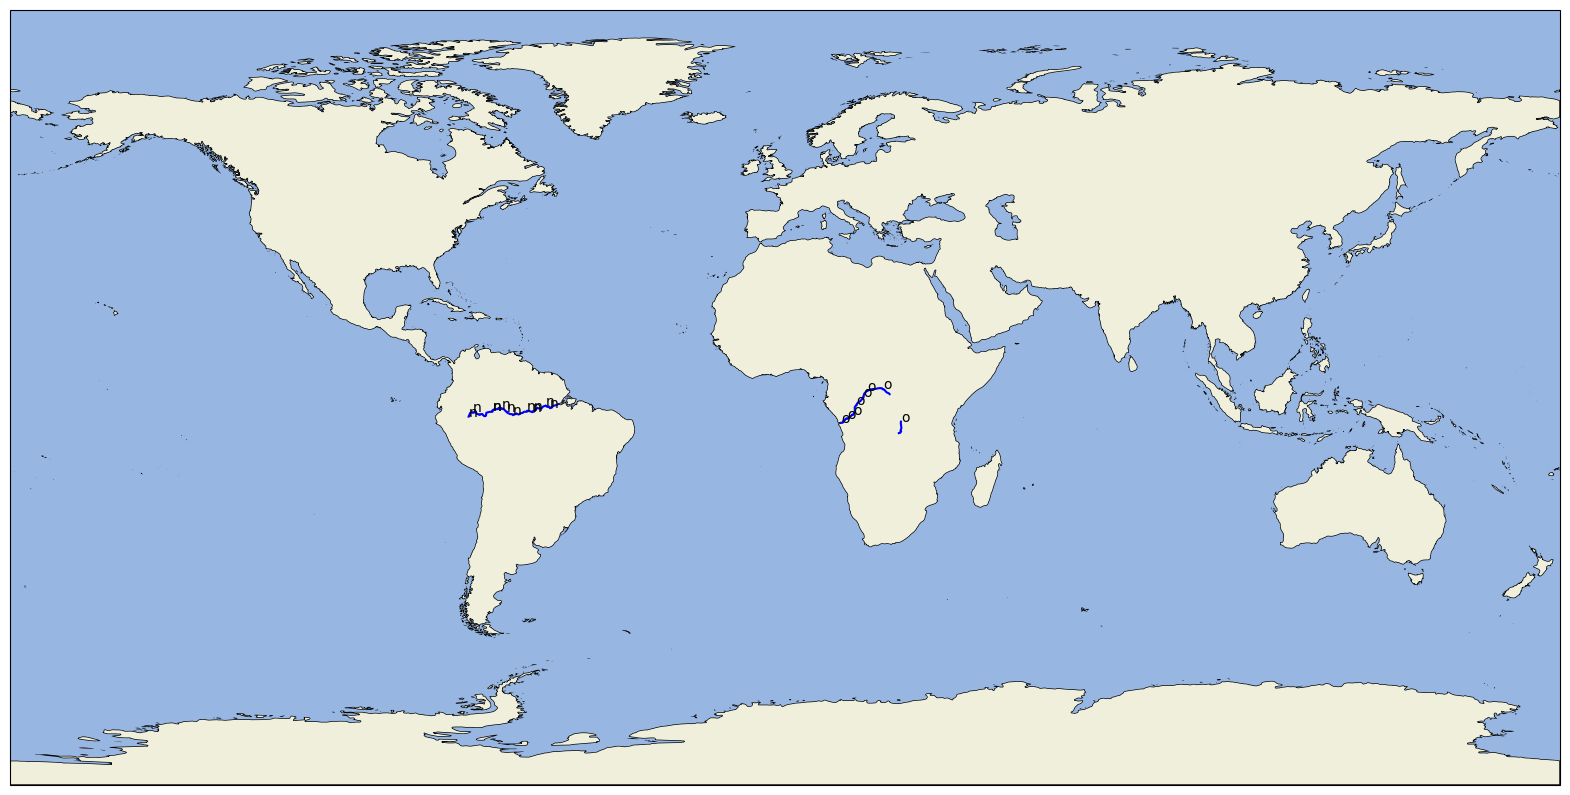

In [232]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the shapefile
gdf = gpd.read_file('/home/guido/Dropbox/ipynb/estuary/ne_50m_rivers_lake_centerlines_scale_rank.shp')
print(gdf.columns)

# Filter the data to include only major rivers
#major_rivers = gdf[gdf['scalerank'] < 2]
rivers_to_label = ['Amazon', 'Congo']  # add the names of the rivers you want to label
major_rivers = gdf[gdf['name_en'].isin(rivers_to_label)]
#print(major_rivers)
# Create a new matplotlib figure and axes using Cartopy projection
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor=cfeature.COLORS['land'], edgecolor='black')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor=cfeature.COLORS['water'])
# Plot each major river and label it
for i, row in major_rivers.iterrows():
    ax.plot(row['geometry'].xy[0], row['geometry'].xy[1], color='blue')
    
    # Label the rivers at the endpoint
    endpoint = row['geometry'].coords[-1]
    ax.text(endpoint[0], endpoint[1], row['name_en'][-1], fontsize=10)

# Set the map extent
ax.set_global()



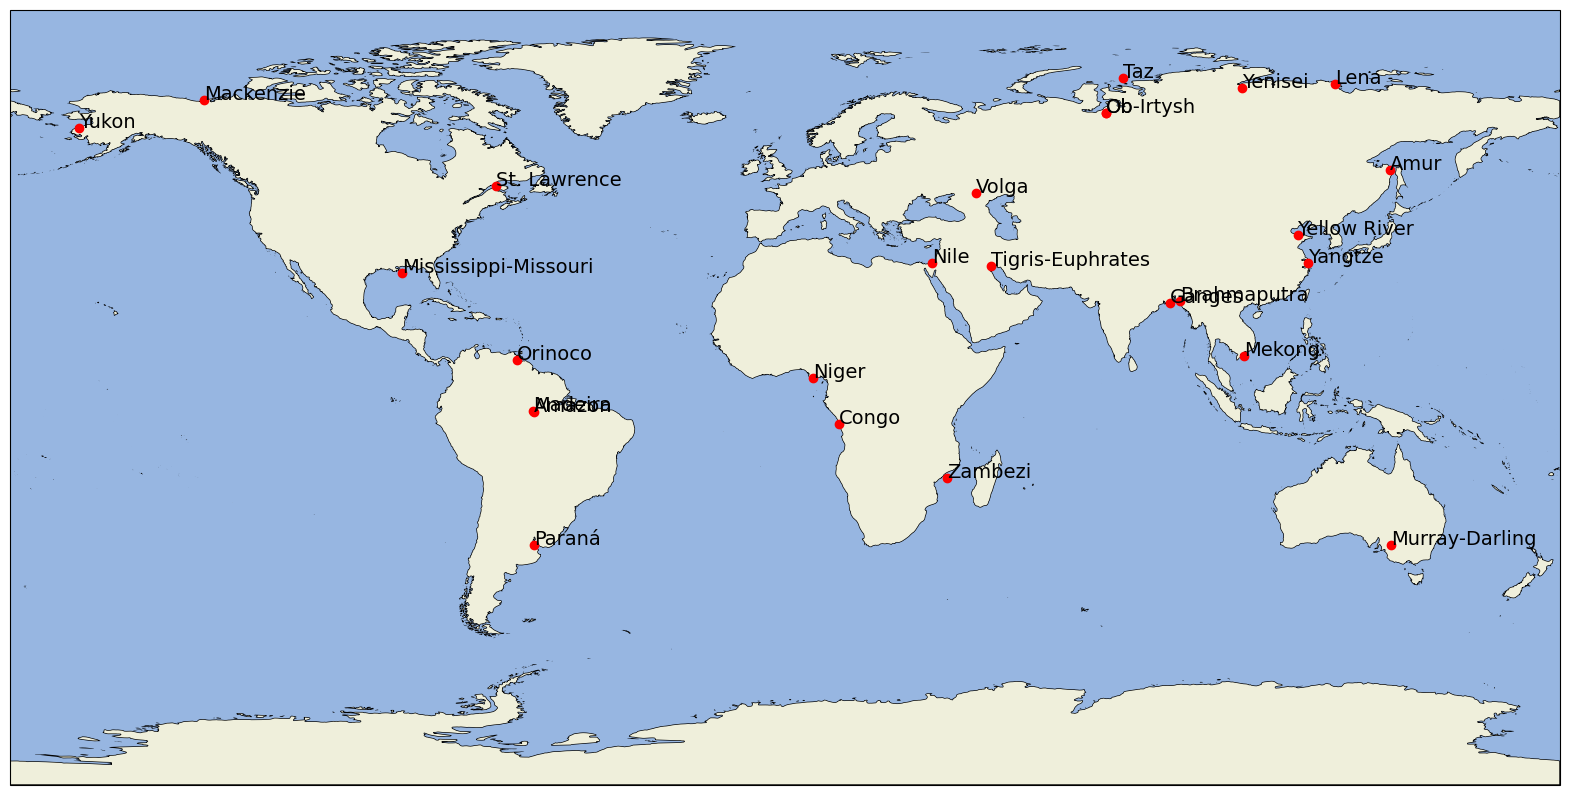

In [233]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# The approximate coordinates for the mouths of some of the world's longest rivers.
river_mouths = {
    'Nile': (34.25, 31.25),
    'Amazon': (-58.3883, -3.4653),
    'Yangtze': (121.4740, 31.2532),
    'Mississippi-Missouri': (-89.0185, 28.9188),
    'Yenisei': (106.1045, 71.8582),
    'Yellow River': (119.0325, 37.6283),
    'Ob-Irtysh': (74.4943, 66.0938),
    'Paraná': (-58.3622, -34.1773),
    'Congo': (12.5050, -6.1253),
    'Amur': (140.5069, 52.7520),
    'Lena': (127.7451, 72.8325),
    'Mekong': (106.7156, 9.5594),
    'Mackenzie': (-135.0107, 69.1624),
    'Niger': (6.4461, 4.5121),
    'Brahmaputra': (91.7832, 22.3569),
    'Zambezi': (37.7347, -18.6483),
    'Volga': (44.3642, 47.4877),
    'Murray-Darling': (140.8003, -34.1965),
    'Tigris-Euphrates': (47.7834, 30.5075),
    'Madeira': (-58.4449, -3.1423),
    'Ganges': (89.3467, 21.9445),
    'Yukon': (-164.0714, 62.5759),  # New addition
    'St. Lawrence': (-67.1492, 49.1256),  # New addition
    'Ob': (74.4943, 66.0938),  # New addition
    'Orinoco': (-62.3333, 8.6000),  # New addition
    'Taz': (78.5, 74.3),  # New addition

}

# Create a new matplotlib figure and axes using Cartopy projection
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor=cfeature.COLORS['land'], edgecolor='black')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor=cfeature.COLORS['water'])

# Plot each river mouth and label it
for river, (lon, lat) in river_mouths.items():
    ax.plot(lon, lat, 'ro')  # Plot the river mouth
    ax.text(lon, lat, river, fontsize=14)  # Label the river mouth

# Set the map extent
ax.set_global()

# Show the map
plt.show()


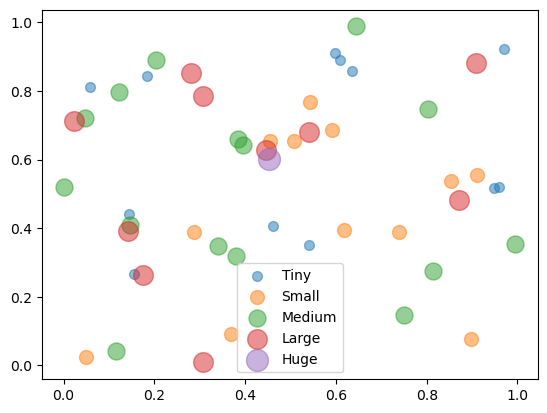

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

N = 50
M = 5 # Number of bins

x = np.random.rand(N)
y = np.random.rand(N)
a2 = 400*np.random.rand(N)

# Create the DataFrame from your randomised data and bin it using groupby.
df = pd.DataFrame(data=dict(x=x, y=y, a2=a2))
bins = np.linspace(df.a2.min(), df.a2.max(), M)
grouped = df.groupby(np.digitize(df.a2, bins))

# Create some sizes and some labels.
sizes = [50*(i+1.) for i in range(M)]
labels = ['Tiny', 'Small', 'Medium', 'Large', 'Huge']

for i, (name, group) in enumerate(grouped):
    plt.scatter(group.x, group.y, s=sizes[i], alpha=0.5, label=labels[i])

plt.legend()

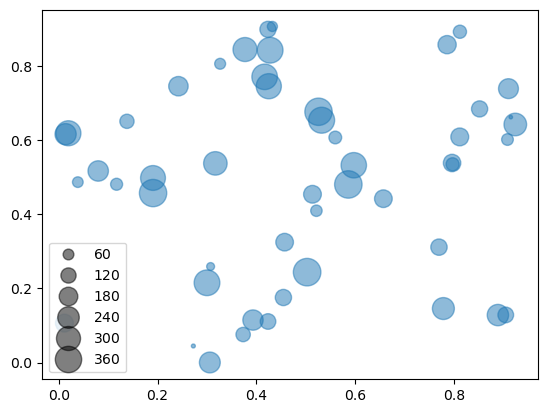

In [235]:
import numpy as np
import matplotlib.pyplot as plt

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
a2 = 400*np.random.rand(N)

sc = plt.scatter(x, y, s=a2, alpha=0.5)
plt.legend(*sc.legend_elements("sizes", num=6))
#print(sc.legend_elements("sizes", num=6))
#plt.show()

In [236]:
# get the response in the form of html
wikiurl='https://en.wikipedia.org/wiki/List_of_rivers_by_discharge'
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [237]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

In [238]:
#convert to pd dataframe
df=pd.read_html(str(indiatable))
# convert list to dataframe
df=pd.DataFrame(df[0])

# drop the unwanted columns
wikirivdata = df.drop(["No", "Continent", "Outflow", "Type"], axis=1)

/tmp/ipykernel_36817/3997201042.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(indiatable))
/tmp/ipykernel_36817/3997201042.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wikirivdata = df.drop(["No", "Continent", "Outflow", "Type"], axis=1)


In [239]:
ebm_params = xr.open_dataset("data/EBMparm_HU20HL20_gx1v6.20170312.nc", engine='netcdf4')

In [240]:
ebm_params

<xarray.Dataset>
Dimensions:   (ny: 384, nx: 320)
Dimensions without coordinates: ny, nx
Data variables:
    tide_amp  (ny, nx) float64 ...
    W_h       (ny, nx) float64 ...
    H         (ny, nx) float64 ...
    a1        (ny, nx) float64 ...
    a2        (ny, nx) float64 ...
    h0        (ny, nx) float64 ...
    h_upper   (ny, nx) float64 ...
    h_lower   (ny, nx) float64 ...

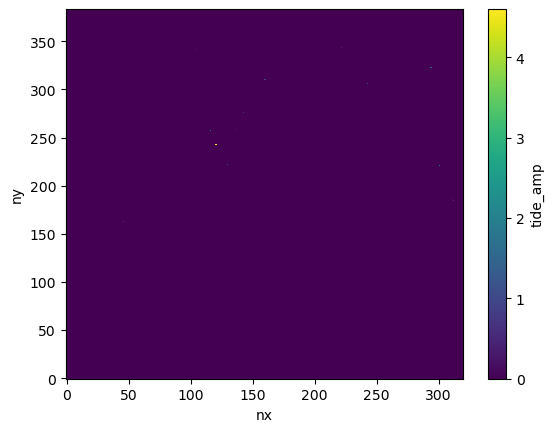

In [241]:
ebm_params["tide_amp"].plot()

In [242]:
riv_params = xr.open_dataset("data/riv_nut.gnews_gnm.gx1v7_nn_open_ocean_nnsm_e1000r300_marginal_sea.20170425.nc", engine='netcdf4')

In [243]:
riv_params

<xarray.Dataset>
Dimensions:                       (nlat: 384, nlon: 320, time: 21)
Coordinates:
    TLAT                          (nlat, nlon) float64 ...
    TLONG                         (nlat, nlon) float64 ...
  * time                          (time) object 1900-07-01 12:00:00 ... 2000-...
Dimensions without coordinates: nlat, nlon
Data variables: (12/23)
    KMT                           (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
    dsi_riv_flux                  (time, nlat, nlon) float64 ...
    pp_riv_flux_gnews             (nlat, nlon) float64 ...
    discharge_riv_flux_IMAGE_GNM  (time, nlat, nlon) float64 ...
    pn_riv_flux                   (time, nlat, nlon) float64 ...
    ...                            ...
    don_riv_flux                  (time, nlat, nlon) float64 ...
    alk_riv_flux                  (time, nlat, nlon) float64 ...
    pp_riv_flux                   (time, nlat, nlon) float64 ...
    dfe_riv_flux                  (time, nlat, nlon) float64 ...
    don_riv_flux_gnews            (nlat, nlon) float64 ...
    poc_riv_flux                  (time, nlat, nlon) float64 ...
Attributes:
    note:         Created by M. Long (NCAR) 2017-04-25
    source:       Blend of GlobalNEWS and IMAGE-GNM data: GlobalNEWS: https:/...
    assumptions:  Dissolved inorganic carbon (DIC) in freshwater inputs is as...
    mapping:      Nutrient file on runoff grid: /glade/p/work/mclong/cesm_inp...
    procedure:    Data sets were interpolated to the runoff grid, then mapped...

In [244]:
rivlats = riv_params.TLAT
rivlons = riv_params.TLONG

In [245]:
rivlats

<xarray.DataArray 'TLAT' (nlat: 384, nlon: 320)>
[122880 values with dtype=float64]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [246]:
lontest = rivdf.x[0]
lattest = rivdf.y[0]

In [247]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + \
        np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * \
        np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def nearest_ij(LATS, LONS, lat, lon):
    distances = haversine(LATS, LONS, lat, lon)
    return np.unravel_index(distances.argmin(), distances.shape)

# example usage
LATS = np.random.uniform(-90, 90, (100, 100))  # 100x100 grid of latitudes
LONS = np.random.uniform(-180, 180, (100, 100))  # 100x100 grid of longitudes
lat, lon = 0, 0  # example: New York City
i, j = nearest_ij(rivlats, rivlons, lat, lon)
print(i, j)


187 35


In [248]:
print(lontest)
print(lattest)

-57.5
-34.5


In [249]:
i, j = nearest_ij(rivlats, rivlons, lattest, lontest)
print(i, j)

84 304


In [250]:
ebm_params.isel(ny=i, nx=j).H.values

array(0.)

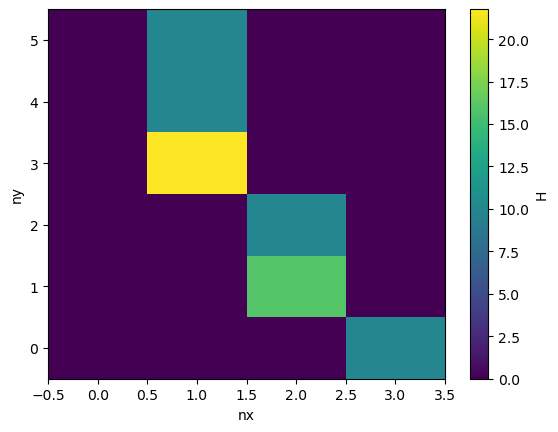

In [251]:
ebm_params["H"].isel(nx=slice(310,314), ny=slice(184,190)).plot()

In [252]:
ebm_params["H"].isel(nx=311, ny=187).values

array(21.767)

In [253]:
i, j = nearest_ij(rivlats, rivlons, -0.5, -51.5)
print(i, j)

185 309


In [254]:
ebm_params.tide_amp.isel(nx=311, ny=187).values

array(0.3253)

In [255]:
ebm_params

<xarray.Dataset>
Dimensions:   (ny: 384, nx: 320)
Dimensions without coordinates: ny, nx
Data variables:
    tide_amp  (ny, nx) float64 ...
    W_h       (ny, nx) float64 ...
    H         (ny, nx) float64 ...
    a1        (ny, nx) float64 ...
    a2        (ny, nx) float64 ...
    h0        (ny, nx) float64 ...
    h_upper   (ny, nx) float64 ...
    h_lower   (ny, nx) float64 ...

In [256]:
rivdf.sort_values(by='largerivers').x.values

array([  95.5,  -55.5,   88.5,  106.5, -164.5,  -49.5,  105.5,  -67.5,
        140.5,   89.5,  -57.5,  -91.5, -134.5,   69.5,  120.5,  -61.5,
         12.5,  126.5,   83.5,  -51.5])

In [257]:
rivdf.sort_values(by='largerivers').y.values

array([ 17.5,  -2.5,  24.5,  73.5,  62.5,  -1.5,  12.5,  48.5,  51.5,
        24.5, -34.5,  30.5,  68.5,  66.5,  32.5,   9.5,  -5.5,  72.5,
        70.5,  -0.5])

In [258]:
# The approximate coordinates for the mouths of some of the world's longest rivers.
river_mouths = {
    'Nile': (34.25, 31.25),
    #'Madeira': (-58.4449, -3.1423),
    'Amazon': (-58.3883, -3.4653),
    'Yangtze': (121.4740, 31.2532),
    'Mississippi-Missouri': (-89.0185, 28.9188),
    #'Yenisei': (106.1045, 71.8582),
    'Yenisei': (99.1045, 68.8582),
    'Yellow River': (119.0325, 37.6283),
    #'Ob-Irtysh': (74.4943, 66.0938),
    'Paraná': (-58.3622, -34.1773),
    'Congo': (12.5050, -6.1253),
    'Amur': (140.5069, 52.7520),
    'Lena': (127.7451, 72.8325),
    'Mekong': (106.7156, 9.5594),
    'Mackenzie': (-135.0107, 69.1624),
    'Niger': (6.4461, 4.5121),
    #'Brahmaputra': (91.7832, 22.3569),
    'Brahmaputra': (91.7832, 16),
    'Zambezi': (37.7347, -18.6483),
    'Volga': (44.3642, 47.4877),
    #'Murray-Darling': (140.8003, -34.1965),
    'Tigris-Euphrates': (47.7834, 30.5075),
    'Ganges': (89.3467, 21.9445),
    'Yukon': (-164.0714, 62.5759),  # New addition
    'St. Lawrence': (-67.1492, 49.1256),  # New addition
    #'Ob': (74.4943, 66.0938),  # New addition
    'Ob': (70.4943, 66.0938),  # New addition
    'Orinoco': (-62.3333, 8.6000),  # New addition
    'Taz': (78.5, 74.3),  # New addition

}


180
20
[0.0010505188893509894, 0.004263726904489673, 0.007476934919628355, 0.010690142934767038, 0.013903350949905722]


/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


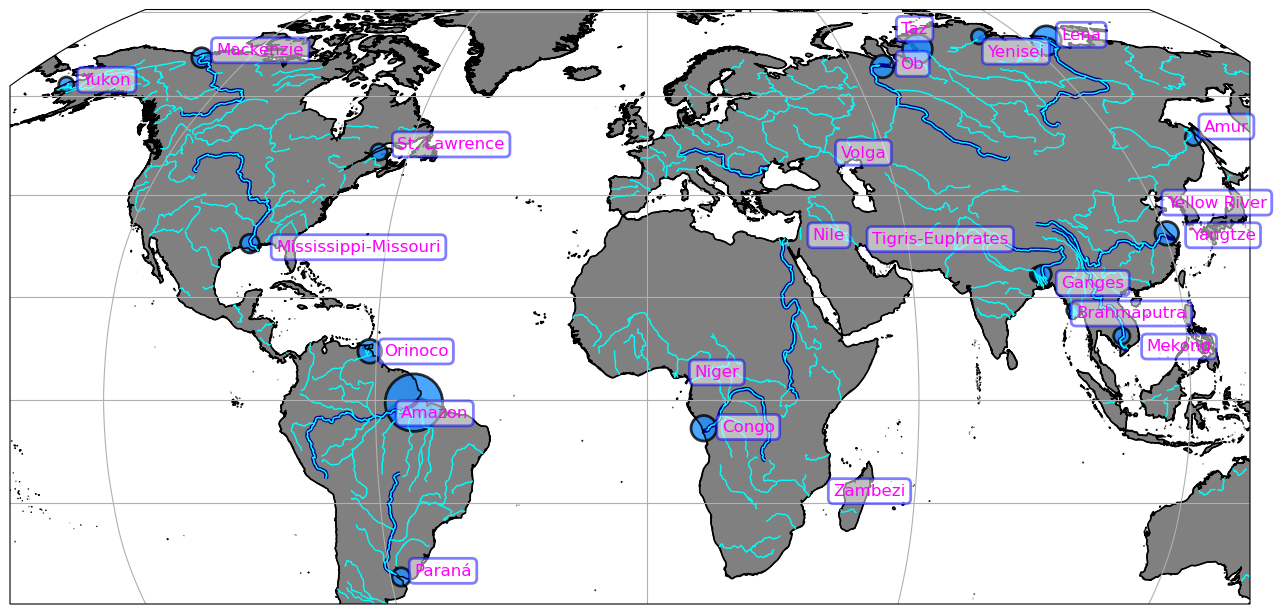

In [259]:
#cutoff kg/s/m^2
cutoff = 0.001
rivrunoff = riv_obs.runoff.isel(nt=0)
largerivers = rivrunoff.where(rivrunoff.values > cutoff)
xpos = riv_obs.xc.where(largerivers > cutoff)
ypos = riv_obs.yc.where(largerivers > cutoff)
print(len(largerivers.values))
M = 5 # Number of bins

water_color='cyan'
water_color_main='darkblue'

non_nan_rivdata = largerivers.values[np.isfinite(largerivers.values)]
non_nan_rivx = xpos.values[np.isfinite(xpos.values)]
non_nan_rivy = ypos.values[np.isfinite(ypos.values)]

rivdf = pd.DataFrame(data=dict(x=non_nan_rivx, y=non_nan_rivy, largerivers=non_nan_rivdata)) 
N=rivdf.shape[0] # number of big rivers
print(N)
# Create the DataFrame from your randomised data and bin it using groupby.
#df = pd.DataFrame(data=dict(x=xpos, y=ypos, largerivers=largerivers))
bins = np.linspace(rivdf.largerivers.min(), rivdf.largerivers.max(), M)
grouped = rivdf.groupby(np.digitize(rivdf.largerivers, bins))

fig=plt.figure(figsize=(16,10))
ax = plt.subplot(111, projection=ccrs.Robinson())
#ax = plt.subplot(111, projection=ccrs.PlateCarree())
#ax.set_global()

#ax.add_feature(cfeature.COASTLINE, edgecolor="black")
#ax.add_feature(cfeature.BORDERS, edgecolor="brown")
#ax.add_feature(cfeature.RIVERS, edgecolor="blue")
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='k', 
                                            facecolor='gray'), zorder=0)
ax.add_feature(cfeature.RIVERS, color=water_color_main, edgecolor=water_color_main, linewidth=3.0)                                   
ax.coastlines(linewidth=1)

# add higher resolution rivers
shp_path = cc.io.shapereader.natural_earth(
        resolution='50m',
        category='physical',
        name='rivers_lake_centerlines')
shp_contents = cc.io.shapereader.Reader(shp_path)
river_generator = shp_contents.geometries()
river_feature = cc.feature.ShapelyFeature(
        river_generator,
        cc.crs.PlateCarree(),
        edgecolor=water_color,
        facecolor='none')
ax.add_feature(river_feature)


#ax.set_facecolor("gray")
ax.gridlines()
#ax.set_extent(
#ax.scatter(riv_obs.xc, riv_obs.yc, largerivers)

largemin = rivdf.largerivers.min()
largemax = rivdf.largerivers.max()
# Create some sizes and some labels.
rivdel = (largemax-largemin)/M
sizes = [largemin+i*rivdel for i in range(M)]
print(sizes)
labels = [ str(np.round(sizes[i],1)) for i in range(M)]

#for i, (name, group) in enumerate(grouped):
#    print(i)
#    print(name)
#    print(group.x)
#    ax.scatter(group.x, group.y, s=sizes[i]*100000, alpha=0.8, label=labels[i], transform=ccrs.PlateCarree() )

#ax.legend()


scatp = ax.scatter(x=xpos, y=ypos,
            color="dodgerblue",
            edgecolor='black',
            lw=2.0,
            s=largerivers*100000,
            alpha=0.8,
            transform=ccrs.PlateCarree()) ## Important

#plt.legend(*scatp.legend_elements("sizes", num=6))

# Create the legend handles and labels
#handles, labels = scatp.legend_elements(prop="sizes", num=6)
#print(handles, labels)
#labels = [f"{size}" for size in labels]  # Convert sizes to string labels

# Create the legend with custom circles
#legend = ax.legend(handles, labels, loc="upper left", title="River Runoff\n(kg m$^{-2}$ s$^{-1}$)")
#for handle in legend.legendHandles:
#    handle.set_sizes([50])

# bbox properties
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2, alpha=0.5)

# Plot each river mouth and label it
for river, (lon, lat) in river_mouths.items():
    #ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())  # Plot the river mouth
    ax.text(lon+4, lat, river, fontsize=12, color='magenta', bbox=bbox_props, transform=ccrs.PlateCarree())  # Label the river mouth

icepaperdir="/home/guido/Dropbox/plots/estuaries/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"Figure_rivermap.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure_rivermap.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


In [260]:
def calc_max10(roff_f):
    # Assuming 'roff_f' is your xarray.DataArray with dimensions ('nlat', 384) and ('nlon', 320)
    # Replace 'roff_f' with the actual variable name of your DataArray
    # Find the 10 largest values and their indices
    largest_values = roff_f.fillna(0).values.flatten()
    sorted_indices = np.argsort(largest_values)[::-1][:10]  # Indices of 10 largest values
    largest_values = largest_values[sorted_indices]  # 10 largest values
    largest_indices = np.unravel_index(sorted_indices, roff_f.shape)  # Convert to 2D indices
    
    # Create a variable to store these three things
    result = {
        "values": largest_values,
        "row_indices": largest_indices[0],
        "column_indices": largest_indices[1]
    }

    return result

def calc_max10_diff(groff, broff):
    
    roff_diff = groff - broff
    # Find the 10 largest values and their indices
    largest_values_diff = roff_diff.fillna(0).values.flatten()
    sorted_indices_diff = np.argsort(largest_values_diff)[::-1][:10]  # Indices of 10 largest values
    largest_values_diff = largest_values_diff[sorted_indices_diff]  # 10 largest values
    largest_indices_diff = np.unravel_index(sorted_indices_diff, roff_diff.shape)  # Convert to 2D indices
    
    # Create a variable to store these three things
    result_diff = {
        "values": largest_values_diff,
        "row_indices": largest_indices_diff[0],
        "column_indices": largest_indices_diff[1]
    }

    return result_diff


In [261]:
g10roff = calc_max10(gebm_ROFF_ocn)

In [262]:
b10roff = calc_max10(bebm_ROFF_ocn)

In [263]:
g10roff["values"] -  b10roff["values"]

array([ 0.02984489, -0.01274786,  0.00092791, -0.00175328, -0.00249458,
       -0.0022026 , -0.00221364, -0.0013683 , -0.00159725, -0.00123034],
      dtype=float32)

In [264]:
roff_max10_diff = calc_max10_diff(gebm_ROFF_ocn, bebm_ROFF_ocn)
roff_max10_diff["values"]

array([0.02984489, 0.01120031, 0.01004465, 0.00446155, 0.00346919,
       0.00334561, 0.00290576, 0.00246821, 0.00219569, 0.00206282],
      dtype=float32)

In [265]:
def plot_rivermap(ax):
    riverfontsize = 8
    cutoff = 0.001
    rivrunoff = riv_obs.runoff.isel(nt=0)
    largerivers = rivrunoff.where(rivrunoff.values > cutoff)
    xpos = riv_obs.xc.where(largerivers > cutoff)
    ypos = riv_obs.yc.where(largerivers > cutoff)
    print(len(largerivers.values))
    M = 5 # Number of bins
    
    water_color='cyan'
    water_color_main='darkblue'
    
    non_nan_rivdata = largerivers.values[np.isfinite(largerivers.values)]
    non_nan_rivx = xpos.values[np.isfinite(xpos.values)]
    non_nan_rivy = ypos.values[np.isfinite(ypos.values)]
    
    rivdf = pd.DataFrame(data=dict(x=non_nan_rivx, y=non_nan_rivy, largerivers=non_nan_rivdata)) 
    N=rivdf.shape[0] # number of big rivers
    print(N)
    # Create the DataFrame from your randomised data and bin it using groupby.
    #df = pd.DataFrame(data=dict(x=xpos, y=ypos, largerivers=largerivers))
    bins = np.linspace(rivdf.largerivers.min(), rivdf.largerivers.max(), M)
    grouped = rivdf.groupby(np.digitize(rivdf.largerivers, bins))
    
    #fig=plt.figure(figsize=(16,10))
    #ax = plt.subplot(111, projection=ccrs.Robinson())
    #ax = plt.subplot(111, projection=ccrs.PlateCarree())
    #ax.set_global()
    
    #ax.add_feature(cfeature.COASTLINE, edgecolor="black")
    #ax.add_feature(cfeature.BORDERS, edgecolor="brown")
    #ax.add_feature(cfeature.RIVERS, edgecolor="blue")
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='k', 
                                                facecolor='gray'), zorder=0)
    ax.add_feature(cfeature.RIVERS, color=water_color_main, edgecolor=water_color_main, linewidth=3.0)                                   
    ax.coastlines(linewidth=1)
    
    # add higher resolution rivers
    shp_path = cc.io.shapereader.natural_earth(
            resolution='50m',
            category='physical',
            name='rivers_lake_centerlines')
    shp_contents = cc.io.shapereader.Reader(shp_path)
    river_generator = shp_contents.geometries()
    river_feature = cc.feature.ShapelyFeature(
            river_generator,
            cc.crs.PlateCarree(),
            edgecolor=water_color,
            facecolor='none')
    ax.add_feature(river_feature)
    
    
    #ax.set_facecolor("gray")
    ax.gridlines()
    #ax.set_extent(
    #ax.scatter(riv_obs.xc, riv_obs.yc, largerivers)
    
    largemin = rivdf.largerivers.min()
    largemax = rivdf.largerivers.max()
    # Create some sizes and some labels.
    rivdel = (largemax-largemin)/M
    sizes = [largemin+i*rivdel for i in range(M)]
    print(sizes)
    labels = [ str(np.round(sizes[i],1)) for i in range(M)]
    
    #for i, (name, group) in enumerate(grouped):
    #    print(i)
    #    print(name)
    #    print(group.x)
    #    ax.scatter(group.x, group.y, s=sizes[i]*100000, alpha=0.8, label=labels[i], transform=ccrs.PlateCarree() )
    
    #ax.legend()
    
    
    scatp = ax.scatter(x=xpos, y=ypos,
                color="dodgerblue",
                edgecolor='black',
                lw=2.0,
                s=largerivers*100000,
                alpha=0.8,
                transform=ccrs.PlateCarree()) ## Important
    
    #plt.legend(*scatp.legend_elements("sizes", num=6))
    
    # Create the legend handles and labels
    #handles, labels = scatp.legend_elements(prop="sizes", num=6)
    #print(handles, labels)
    #labels = [f"{size}" for size in labels]  # Convert sizes to string labels
    
    # Create the legend with custom circles
    #legend = ax.legend(handles, labels, loc="upper left", title="River Runoff\n(kg m$^{-2}$ s$^{-1}$)")
    #for handle in legend.legendHandles:
    #    handle.set_sizes([50])
    
    # bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2, alpha=0.5)
    
    # Plot each river mouth and label it
    for river, (lon, lat) in river_mouths.items():
        #ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())  # Plot the river mouth
        ax.text(lon+4, lat, river, fontsize=riverfontsize, color='magenta', bbox=bbox_props, transform=ccrs.PlateCarree())  # Label the river mouth
    
    #icepaperdir="/home/guido/Dropbox/plots/estuaries/"
    #saveplot=False
    #if saveplot:
    #    plt.savefig(icepaperdir+"Figure_rivermap.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    #    plt.savefig(icepaperdir+"Figure_rivermap.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


In [266]:
g10roff

{'values': array([0.06664755, 0.01127201, 0.01004465, 0.00654078, 0.00556616,
        0.00509632, 0.00480175, 0.00446056, 0.00420804, 0.0042008 ],
       dtype=float32),
 'row_indices': array([187, 164, 223, 345, 342, 340, 185, 227, 276,  83]),
 'column_indices': array([311,  46, 301, 118, 105, 152, 312, 127, 143, 305])}

In [267]:
def plot_grunoff(ax, gbdata, gbmaxdata, title):
    ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
    ax.add_feature(cfeature.OCEAN, color='#eefefe', edgecolor=None)

    data = gbdata.values

    # Apply logarithmic scaling to color
    # Set your min and max values here
    vmin, vmax = 1e-6, 0.004  # Replace with your data's min and max values
    norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

    scaling_factor = 10000.0
    sizes = gbdata.values * scaling_factor

    scatter = ax.scatter(gbdata["TLONG"], gbdata["TLAT"], s=sizes, c=data, 
                         cmap=ocm.cm.matter_r, alpha=1.0, zorder=10, norm=norm)

    # Add colorbar with logarithmic scale
    cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
    cbar.set_label('Runoff Flux (kg/m$^2$/s)')
    ax.set_title(title, size=14)

    # Overlay the top 10 values with black edges
    #ax.scatter(gbdata["TLONG"][gbmaxdata["row_indices"], gbmaxdata["column_indices"]], gbdata["TLAT"][gbmaxdata["row_indices"], gbmaxdata["column_indices"]], 
    #           s=sizes[gbmaxdata["row_indices"],gbmaxdata["column_indices"]], c=None, 
    #           cmap=ocm.cm.matter_r, alpha=1.0, zorder=11, norm=norm, edgecolor='black', linewidths=1)

# Example usage
# fig, ax = plt.subplots(subplot_kw={'projection': 'your_projection_here'})
# plot_grunoff(ax, your_gbdata, 'Your Title')
# plt.show()


In [268]:
sizes

[0.0010505188893509894,
 0.004263726904489673,
 0.007476934919628355,
 0.010690142934767038,
 0.013903350949905722]

In [269]:
def plot_brunoff(ax, gbdata, title):
    # either
    #woce_mask_rg.REGION_MASK.where(woce_mask_rg.REGION_MASK == 0).plot(cmap=plt.cm.bwr, add_colorbar=False)
    # or
    ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
    ax.add_feature(cfeature.OCEAN, color='#eefefe', edgecolor=None)
    # Define the colormap
    cmap = plt.cm.Blues
    # The ROFF_F values will determine the size of the scatter plot points
    # We apply some scaling factor to make the size differences visible
    data = gbdata.values
    # Normalize the size of the scatter points
    csize = (data / np.max(data)) # Size scaling for color, assumes data is always positive
    
    
    scaling_factor = 10000.0
    sizes = gbdata.values * scaling_factor  # scaling_factor depends on your data range and preference
    
    scatter = ax.scatter(gbdata["TLONG"], gbdata["TLAT"], s=sizes, c=data, cmap=ocm.cm.matter_r, alpha=1.0, zorder = 10)
    
    # Set the colorbar to respect your limits of 0 to 0.004 kg/m^2/s
    pcm.set_clim(0, 0.004)
    
    
    # Add colorbar
    #plt.colorbar(pcm, ax=ax, extend='max', orientation='vertical', label='Runoff Flux (kg/m^2/s)')
    # Add a colorbar with a label.
    cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
    cbar.set_label('Runoff Flux (kg/m$^2$/s)')
    ax.set_title(title, size=14)

    # Define the bounding box for the inset axes in axes coordinates (0 to 1)
    #inset_left = 0.5 # X position of the lower left corner
    #inset_bottom = 0.05 # Y position of the lower left corner
    #inset_width = 0.6  # Inset width relative to the parent axes
    #inset_height = 0.8 # Inset height relative to the parent axes
    ## The bbox_to_anchor is a 4-tuple of (x0, y0, width, height)
    #bbox_to_anchor = (inset_left, inset_bottom, inset_width, inset_height)
    ##inset_ax_exp = inset_axes(ax,
    ##                      width="70%",  # Width of the inset relative to parent axes
    ##                      height="30%",  # Height of the inset relative to parent axes
    ##                      loc='center',   # Position of the inset within the parent axes
    ##                      bbox_to_anchor=bbox_to_anchor,
    ##                      bbox_transform=ax.transAxes,  # Coordinate system transformation (using parent axes)
    ##                      borderpad=2  # Padding between inset and parent axes
    ##                     )
    ## Create an inset with standard matplotlib axes
    #inset_ax = ax.inset_axes([0.45, 0.1, 0.5, 0.16]) # Adjust the position and size as needed
    ## Assuming 'result' contains the largest values and their indices from the previous step
    #result = g10roff["values"] -  b10roff["values"]
    ###indices = 
    #indices = list(zip(result['row_indices'], result['column_indices']))
    
    ## Creating a histogram with labels
    #inset_ax.bar(range(len(values[0:5])), values[0:5], tick_label="")
    #inset_ax.xlabel('Index (Row, Column)')
    #inset_ax.ylabel('Value')
    #inset_ax.title('Top 10 Values in DataArray')
    #inset_ax.xticks(rotation=45)

180
20
[0.0010505188893509894, 0.004263726904489673, 0.007476934919628355, 0.010690142934767038, 0.013903350949905722]


/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 *

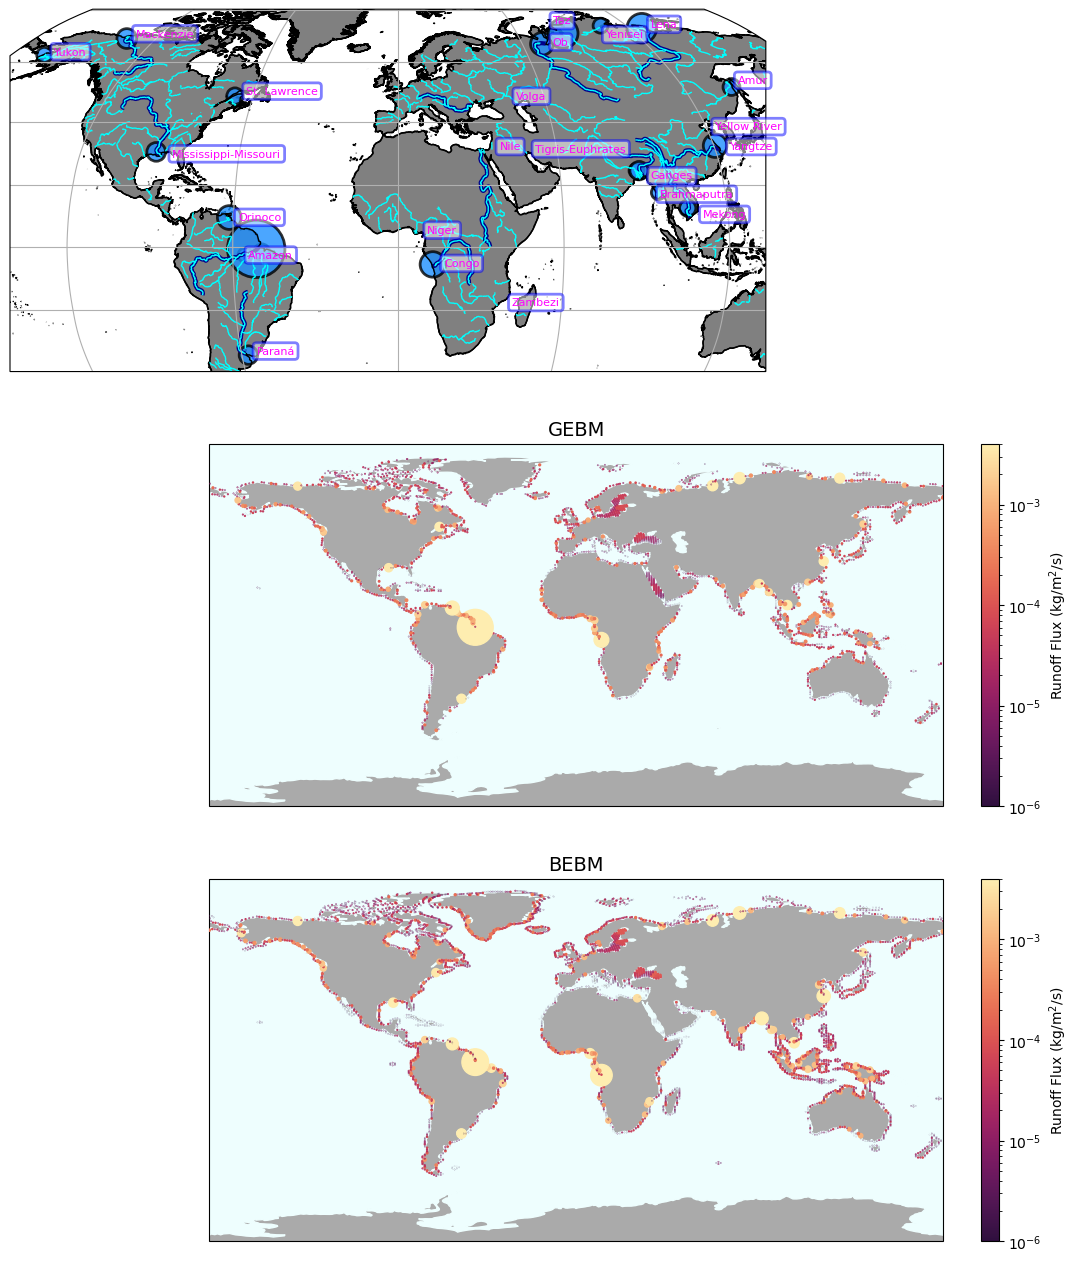

In [270]:
fig=plt.figure(figsize=(16,16))
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Robinson()

ax0 = plt.subplot(311, projection=proj2)
ax1 = plt.subplot(312, projection=proj1)
ax2 = plt.subplot(313, projection=proj1)

plot_rivermap(ax0)
plot_grunoff(ax1, gebm_ROFF_ocn, g10roff, "GEBM")
plot_grunoff(ax2, bebm_ROFF_ocn, b10roff, "BEBM")

In [271]:
def plot_grunoff_lab_nooutline(ax, gbdata, title):
    riverfontsize = 8
    cutoff = 0.001
    rivrunoff = riv_obs.runoff.isel(nt=0)
    largerivers = rivrunoff.where(rivrunoff.values > cutoff)
    xpos = riv_obs.xc.where(largerivers > cutoff)
    ypos = riv_obs.yc.where(largerivers > cutoff)
    print(len(largerivers.values))
    M = 5 # Number of bins
    
    water_color='cyan'
    water_color_main='darkblue'
    
    non_nan_rivdata = largerivers.values[np.isfinite(largerivers.values)]
    non_nan_rivx = xpos.values[np.isfinite(xpos.values)]
    non_nan_rivy = ypos.values[np.isfinite(ypos.values)]
    
    rivdf = pd.DataFrame(data=dict(x=non_nan_rivx, y=non_nan_rivy, largerivers=non_nan_rivdata)) 
    N=rivdf.shape[0] # number of big rivers
    print(N)
    # Create the DataFrame from your randomised data and bin it using groupby.
    #df = pd.DataFrame(data=dict(x=xpos, y=ypos, largerivers=largerivers))
    bins = np.linspace(rivdf.largerivers.min(), rivdf.largerivers.max(), M)
    grouped = rivdf.groupby(np.digitize(rivdf.largerivers, bins))
    ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
    ax.add_feature(cfeature.OCEAN, color='#eefefe', edgecolor=None)
    #ax.add_feature(cfeature.RIVERS, color=water_color_main, edgecolor=water_color_main, linewidth=3.0)                                   
    # add higher resolution rivers
    shp_path = cc.io.shapereader.natural_earth(
            resolution='50m',
            category='physical',
            name='rivers_lake_centerlines')
    shp_contents = cc.io.shapereader.Reader(shp_path)
    river_generator = shp_contents.geometries()
    river_feature = cc.feature.ShapelyFeature(
            river_generator,
            cc.crs.PlateCarree(),
            edgecolor=water_color,
            facecolor='none')
    ax.add_feature(river_feature)

    data = gbdata.values

    # Apply logarithmic scaling to color
    # Set your min and max values here
    vmin, vmax = 1e-6, 0.004  # Replace with your data's min and max values
    norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

    scaling_factor = 10000.0
    sizes = gbdata.values * scaling_factor

    scatter = ax.scatter(gbdata["TLONG"], gbdata["TLAT"], s=sizes, c=data, 
                         cmap=ocm.cm.matter_r, alpha=1.0, zorder=10, norm=norm)

    # Add colorbar with logarithmic scale
    cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
    cbar.set_label('Runoff Flux (kg/m$^2$/s)')
    ax.set_title(title, size=14)
    # bbox properties
    #bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2, alpha=0.5)
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec=None, lw=0, alpha=0.5)
    
    # Plot each river mouth and label it
    for river, (lon, lat) in river_mouths.items():
        #ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())  # Plot the river mouth
        ax.text(lon+4, lat, river, fontsize=riverfontsize, color='magenta', bbox=bbox_props, transform=ccrs.PlateCarree(), zorder=10)  # Label the river mouth



180
20
[0.0010505188893509894, 0.004263726904489673, 0.007476934919628355, 0.010690142934767038, 0.013903350949905722]
180
20
180
20


/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


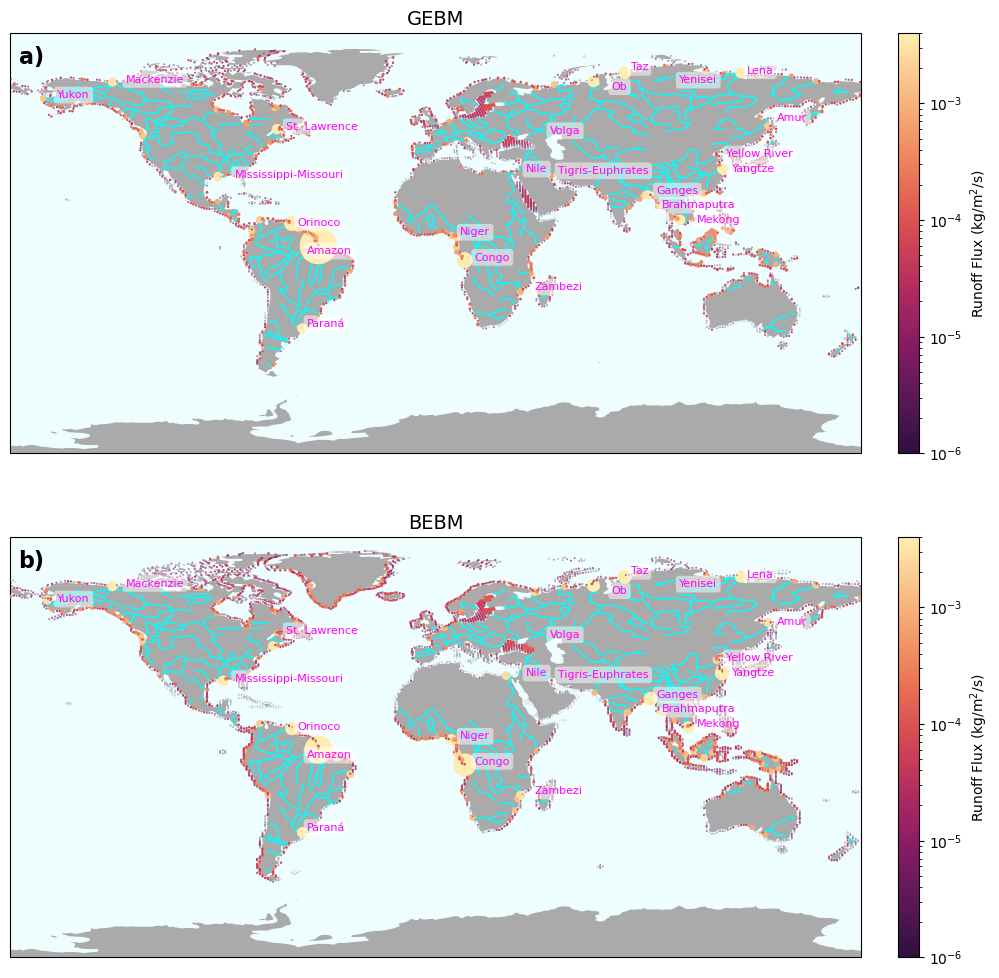

In [272]:
fig=plt.figure(figsize=(16,12))
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Robinson()

#ax0 = plt.subplot(311, projection=proj2)
ax1 = plt.subplot(211, projection=proj1)
ax2 = plt.subplot(212, projection=proj1)

plot_rivermap(ax0)
plot_grunoff_lab_nooutline(ax1, gebm_ROFF_ocn, "GEBM")
plot_grunoff_lab_nooutline(ax2, bebm_ROFF_ocn, "BEBM")

# figure labels (make it look like Nature)
lbfs=16
xl = 0.01
yl = 0.97
ax1.text(xl, yl, "a)", ha='left', va='top', size=lbfs, weight='bold', transform=ax1.transAxes)
ax2.text(xl, yl, "b)", ha='left', va='top', size=lbfs, weight='bold', transform=ax2.transAxes)

# Save figure
icepaperdir = "/home/guido/Dropbox/plots/estuaries/"
saveplot = False
if saveplot:
    plt.savefig(
        icepaperdir + "figure_runoff_scatter.png",
        dpi=300,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
        transparent=False,
    )
    plt.savefig(
        icepaperdir + "figure_runoff_scatter.pdf",
        dpi=300,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
        transparent=False,
    )

In [273]:
g10roff

{'values': array([0.06664755, 0.01127201, 0.01004465, 0.00654078, 0.00556616,
        0.00509632, 0.00480175, 0.00446056, 0.00420804, 0.0042008 ],
       dtype=float32),
 'row_indices': array([187, 164, 223, 345, 342, 340, 185, 227, 276,  83]),
 'column_indices': array([311,  46, 301, 118, 105, 152, 312, 127, 143, 305])}

In [274]:
b10roff

{'values': array([0.03680266, 0.02401987, 0.00911674, 0.00829406, 0.00806074,
        0.00729892, 0.00701539, 0.00582886, 0.00580529, 0.00543114],
       dtype=float32),
 'row_indices': array([187, 163, 276, 257, 345, 221, 342, 340, 185, 222]),
 'column_indices': array([311,  46, 143, 116, 118, 301, 105, 152, 312, 130])}

In [295]:
def calc_max_rivnum(roff_f, rnum):
    # Assuming 'roff_f' is your xarray.DataArray with dimensions ('nlat', 384) and ('nlon', 320)
    # Replace 'roff_f' with the actual variable name of your DataArray
    # Find the 10 largest values and their indices
    largest_values = roff_f.fillna(0).values.flatten()
    sorted_indices = np.argsort(largest_values)[::-1][:rnum]  # Indices of rnum largest values
    largest_values = largest_values[sorted_indices]  # 10 largest values
    largest_indices = np.unravel_index(sorted_indices, roff_f.shape)  # Convert to 2D indices
    
    # Create a variable to store these three things
    result = {
        "values": largest_values,
        "row_indices": largest_indices[0],
        "column_indices": largest_indices[1]
    }

    return result

def calc_max_rivnum_diff(groff, broff, rnum):
    
    roff_diff = groff - broff
    # Find the 10 largest values and their indices
    largest_values_diff = roff_diff.fillna(0).values.flatten()
    sorted_indices_diff = np.argsort(largest_values_diff)[::-1][:rnum]  # Indices of 10 largest values
    largest_values_diff = largest_values_diff[sorted_indices_diff]  # rnum largest values
    largest_indices_diff = np.unravel_index(sorted_indices_diff, roff_diff.shape)  # Convert to 2D indices
    
    # Create a variable to store these three things
    result_diff = {
        "values": largest_values_diff,
        "row_indices": largest_indices_diff[0],
        "column_indices": largest_indices_diff[1]
    }

    return result_diff


In [303]:
gxroff = calc_max_rivnum(gebm_ROFF_ocn, 11)

In [304]:
bxroff = calc_max_rivnum(bebm_ROFF_ocn, 11)

In [305]:
gxroff["values"] -  bxroff["values"]

array([ 0.02984489, -0.01274786,  0.00092791, -0.00175328, -0.00249458,
       -0.0022026 , -0.00221364, -0.0013683 , -0.00159725, -0.00123034,
       -0.00083805], dtype=float32)

In [306]:
roff_maxx_diff = calc_max_rivnum_diff(gebm_ROFF_ocn, bebm_ROFF_ocn, 20)
roff_maxx_diff["values"]

array([0.02984489, 0.01120031, 0.01004465, 0.00446155, 0.00346919,
       0.00334561, 0.00290576, 0.00246821, 0.00219569, 0.00206282,
       0.00194728, 0.00185287, 0.00178213, 0.00177727, 0.00161443,
       0.00160222, 0.00151365, 0.00134918, 0.00125483, 0.00112641],
      dtype=float32)

In [307]:
def plot_grunoff_lab(ax, gbdata, title, river_data):
    riverfontsize = 8
    cutoff = 0.001
    rivrunoff = riv_obs.runoff.isel(nt=0)
    largerivers = rivrunoff.where(rivrunoff.values > cutoff)
    xpos = riv_obs.xc.where(largerivers > cutoff)
    ypos = riv_obs.yc.where(largerivers > cutoff)
    print(len(largerivers.values))
    M = 5 # Number of bins
    
    water_color='cyan'
    water_color_main='darkblue'
    
    non_nan_rivdata = largerivers.values[np.isfinite(largerivers.values)]
    non_nan_rivx = xpos.values[np.isfinite(xpos.values)]
    non_nan_rivy = ypos.values[np.isfinite(ypos.values)]
    
    rivdf = pd.DataFrame(data=dict(x=non_nan_rivx, y=non_nan_rivy, largerivers=non_nan_rivdata)) 
    N=rivdf.shape[0] # number of big rivers
    #print(N)

    bins = np.linspace(rivdf.largerivers.min(), rivdf.largerivers.max(), M)
    grouped = rivdf.groupby(np.digitize(rivdf.largerivers, bins))
    ax.add_feature(cfeature.LAND, color='#aaaaaa', edgecolor=None)
    ax.add_feature(cfeature.OCEAN, color='#eefefe', edgecolor=None)
    #ax.add_feature(cfeature.RIVERS, color=water_color_main, edgecolor=water_color_main, linewidth=3.0)                                   
    # add higher resolution rivers
    shp_path = cc.io.shapereader.natural_earth(
            resolution='50m',
            category='physical',
            name='rivers_lake_centerlines')
    shp_contents = cc.io.shapereader.Reader(shp_path)
    river_generator = shp_contents.geometries()
    river_feature = cc.feature.ShapelyFeature(
            river_generator,
            cc.crs.PlateCarree(),
            edgecolor=water_color,
            facecolor='none')
    ax.add_feature(river_feature)
    ax.set_extent([-180,180,-60,90])
                  
    data = gbdata.values

    # Apply logarithmic scaling to color
    # Set your min and max values here
    vmin, vmax = 1e-6, 0.004  # Replace with your data's min and max values
    norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

    scaling_factor = 10000.0
    sizes = gbdata.values * scaling_factor

    scatter = ax.scatter(gbdata["TLONG"], gbdata["TLAT"], s=sizes, c=data, 
                         cmap=ocm.cm.matter_r, alpha=1.0, zorder=10, norm=norm)

    # Add colorbar with logarithmic scale
    cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.022, pad=0.03)
    cbar.set_label('Runoff Flux (kg/m$^2$/s)')
    ax.set_title(title, size=14)
    # bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec=None, lw=0, alpha=0.5)
    
    # Plot each river mouth and label it
    for river, (lon, lat) in river_mouths.items():
        ax.text(lon+4, lat, river, fontsize=riverfontsize, color='magenta', bbox=bbox_props, transform=ccrs.PlateCarree(), zorder=10)  # Label the river mouth

    # add some black edge color around the largest rivers
    # Correct the indexing for x and y
    x_values = [gbdata["TLONG"][row, col] for row, col in zip(river_data['row_indices'], river_data['column_indices'])]
    y_values = [gbdata["TLAT"][row, col] for row, col in zip(river_data['row_indices'], river_data['column_indices'])]
    
    # Ensure the size array 's' has the same length as x and y
    sizes = [value * 10000 for value in river_data['values']]  # Adjust the scaling factor as needed
    #print(x_values)
    edge_10riv = ax.scatter(
        x=x_values,
        y=y_values,
        s=sizes,
        facecolor='none',  # transparent
        edgecolor='black',
        lw=3.0,
        alpha=0.8,
        transform=ccrs.PlateCarree())


180
180


/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/guido/miniforge3/lib/python3.10/si

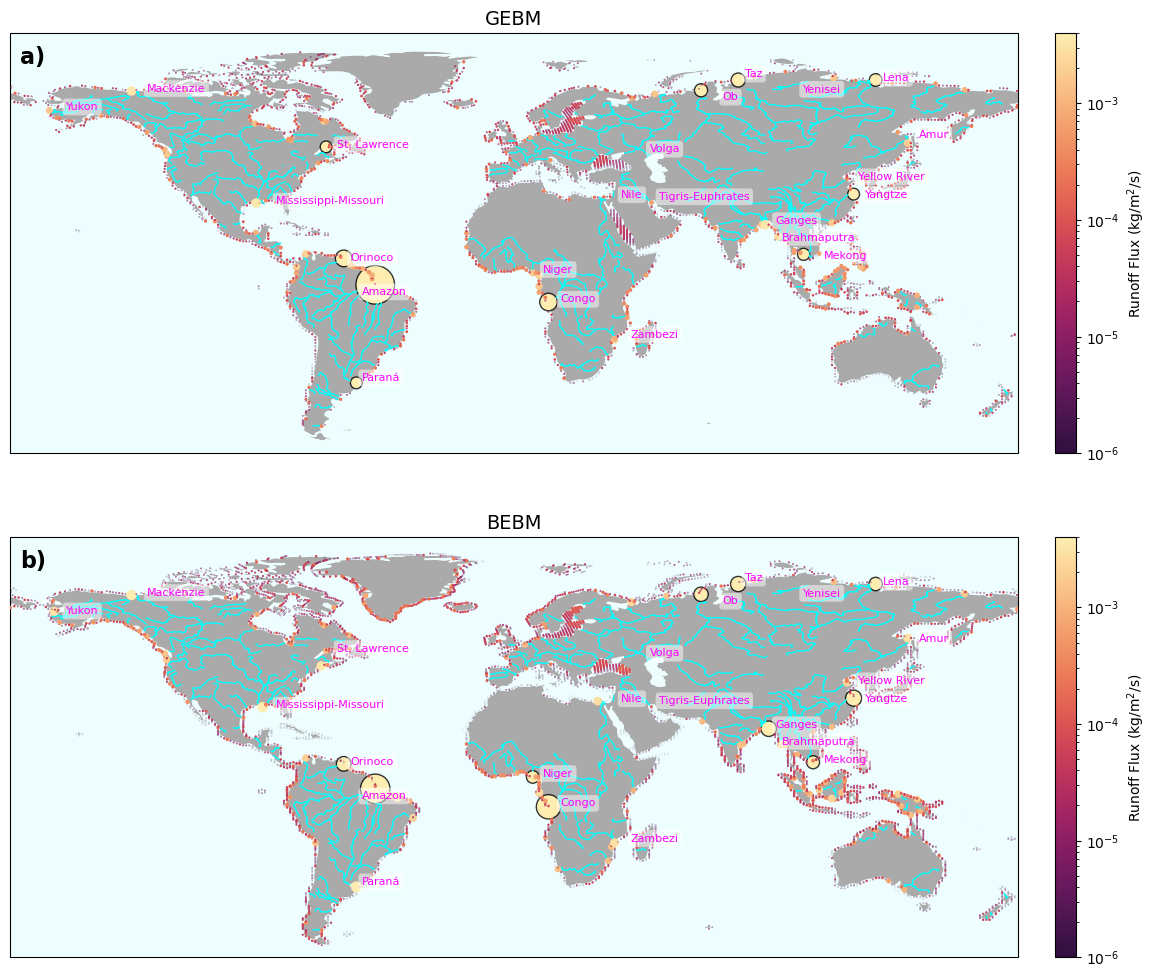

In [309]:
fig=plt.figure(figsize=(16,12))
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Robinson()

#ax0 = plt.subplot(311, projection=proj2)
ax1 = plt.subplot(211, projection=proj1)
ax2 = plt.subplot(212, projection=proj1)

#plot_rivermap(ax0)
plot_grunoff_lab(ax1, gebm_ROFF_ocn, "GEBM", gxroff)
plot_grunoff_lab(ax2, bebm_ROFF_ocn, "BEBM", bxroff)

# #### Try to plot black circles around 10 largest rivers
# For g10roff
g10_values = g10roff['values']
g10_row_indices = g10roff['row_indices']
g10_column_indices = g10roff['column_indices']

# For b10roff
b10_values = b10roff['values']
b10_row_indices = b10roff['row_indices']
b10_column_indices = b10roff['column_indices']



# figure labels (make it look like Nature)
lbfs=16
xl = 0.01
yl = 0.97
ax1.text(xl, yl, "a)", ha='left', va='top', size=lbfs, weight='bold', transform=ax1.transAxes)
ax2.text(xl, yl, "b)", ha='left', va='top', size=lbfs, weight='bold', transform=ax2.transAxes)

# Save figure
icepaperdir = "/home/guido/Dropbox/plots/estuaries/"
saveplot = False
if saveplot:
    plt.savefig(
        icepaperdir + "Figure2_runoff_scatter.png",
        dpi=300,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
        transparent=False,
    )
    plt.savefig(
        icepaperdir + "Figure2_runoff_scatter.pdf",
        dpi=300,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
        transparent=False,
    )